# Physical Model

In [1]:
import os
import sys
sys.path.append("./src")
from soil_models import *
import h5py
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from das_util import get_tstamp
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d

matplotlib.rcParams.update({'font.size': 16})
plt.rcParams['font.family'] = 'Helvetica'


data_dir='./data/'
fig_dir='./figures/'

harper_met = os.path.join(data_dir, 'NewportSalop_merged.csv')
reg_met = os.path.join(data_dir, 'met_newport.csv')
phy_data = os.path.join(data_dir, 'Soil_phy.csv')
phy_data_interpolate = os.path.join(data_dir, 'interpolated_soil_phy.csv')

# Data

## Time information

In [2]:
## Index on the hour
hourly_index = [7,67,127,187,247,299,359,419,466,526,586,646,706,766,826,886,946,1003,1063,1123,
         1183,1243,1302,1362,1422,1482,1542,1599,1659,1719,1779,1839,1899,1959,2019,
         2078,2138,2198,2258,2318]
hourly_index = np.array(hourly_index)

## Soil physical data

In [3]:
### Read the interpolated data
soil_phy = pd.read_csv(phy_data_interpolate)
interp_porosity_10cm = soil_phy['interp_porosity_10cm'].values
interp_porosity_20cm = soil_phy['interp_porosity_20cm'].values
interp_porosity_30cm = soil_phy['interp_porosity_30cm'].values
interp_bulk_density_10cm = soil_phy['interp_bulk_density_10cm'].values
interp_bulk_density_20cm = soil_phy['interp_bulk_density_20cm'].values
interp_bulk_density_30cm = soil_phy['interp_bulk_density_30cm'].values

## PSD and time

In [4]:
with h5py.File(os.path.join(data_dir, 'integrated_psd.hdf5'), 'r') as f:
    int_PSD = f['int_PSD'][:]
    freq = f['freq'][:]
    file_list = f['file_list'][:]

## Mean PSD over channels
ave_psd=np.mean(int_PSD[0:44], axis=0) + 0.0009

acqu_time = np.array([get_tstamp(i) for i in file_list.astype('U')])

Ind6hrs = [7, 359, 706, 1063, 1422, 1779, 2138]

xax=hourly_index[::6]
tax=acqu_time[hourly_index[::6]]
hrax=[dt.strftime('%H') for dt in tax]

## dV/V

In [5]:
with h5py.File(os.path.join(data_dir, 'final_peaks_deRatio_3iterations.h5'), 'r') as f:
# with h5py.File(os.path.join(data_dir, 'final_peaks_deRatio__highpassACF.h5'), 'r') as f:
# with h5py.File(os.path.join(data_dir, 'final_peaks_deRatio.h5'), 'r') as f:
    deratio_dvv = f['deratio_dvv'][:]
print(deratio_dvv.shape)

interp_f = interp1d(np.arange(0,2408,5), deratio_dvv, axis=-1, bounds_error=False, fill_value="extrapolate")
interp_dvv = interp_f(np.arange(2408))
dvv_all = gaussian_filter1d(interp_dvv, sigma=4, axis=-1)
# dvv_all = interp_dvv

(50, 482)


## Disturbance index

In [6]:
disturbance =pd.read_csv(os.path.join(data_dir, 'damage_index.csv'))
disturbance_index = disturbance['dvv_variability'].values/0.88
dyn_types = disturbance['dyn_type'].values

## Regional Met data

In [7]:
### regional weather data
csv_file = pd.read_csv(reg_met)
air_temp = csv_file['Temperature'].to_numpy()
wind_speed = csv_file['Wind Speed'].to_numpy()*1000/3600
humidity = csv_file['Humidity'].to_numpy()

air_temp_interpolated = np.interp(np.arange(0, 2408), np.arange(0, len(air_temp) * 30, 30), air_temp)
wind_speed_interpolated = np.interp(np.arange(0, 2408), np.arange(0, len(wind_speed) * 30, 30), wind_speed)
humidity_interpolated = np.interp(np.arange(0, 2408), np.arange(0, len(humidity) * 30, 30), humidity)


## Met data at farm

In [8]:
### Read the site weather data
csv_file = pd.read_csv(harper_met, low_memory=False).dropna(axis='columns', how='all')
j = 32   ## index of the beginning time
humidity=csv_file['Humidity'][j+1:j+40].to_numpy()
grs_temp = csv_file['Grass Temperature'][j+1:j+40].to_numpy()
air_temp = csv_file['Dry Bulb Temperature'][j+1:j+40].to_numpy()
dew_temp = csv_file['Dew Point Temperature'][j+1:j+40].to_numpy()
soil_temp_30=csv_file['30cm Soil Temperature'][j+1:j+40].to_numpy()
soil_temp_10=csv_file[' 10cm Soil Temperature'][j+1:j+40].to_numpy()
soil_temp_100=csv_file['100cm Soil Temperature'][j+1:j+40].to_numpy()
rainfall = csv_file[' Rainfall Total since 0900'][j:j+40].to_numpy()
rain_diff=np.diff(rainfall)
rain_diff[np.where(rain_diff<0)]=0

interpx = np.arange(2408)
interp_f = interp1d(hourly_index[1:], humidity, bounds_error=False, fill_value="extrapolate")
interp_humidity = interp_f(interpx)
interp_f = interp1d(hourly_index[1:], soil_temp_10, bounds_error=False, fill_value="extrapolate")
interp_temp10 = interp_f(interpx)

air_temp_add1 = np.insert(air_temp, 0, 12)
air_temp_local = np.interp(interpx, np.arange(0, len(air_temp_add1) * 60, 60), air_temp_add1)

### use dew point temperature to calculate the relative humidity
dew_temp_add1 = np.insert(dew_temp, 0, 9)
dew_temp_local = np.interp(np.arange(0, 2408), np.arange(0, len(dew_temp_add1) * 60, 60), dew_temp_add1)
r_humidity = 100 * np.exp((17.27 * dew_temp_local) / (dew_temp_local + 237.3)) / np.exp((17.27 * air_temp_local) / (air_temp_local + 237.3))

## Compare PSD with rainfall, incorporate exponetial drainage

/var/folders/94/_f91r5t1277f16yl_03mnxkw0000gn/T/ipykernel_80331/3495624615.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(fig_dir, 'psd_and_rain.pdf'), dpi=300)
/var/folders/94/_f91r5t1277f16yl_03mnxkw0000gn/T/ipykernel_80331/3495624615.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(fig_dir, 'psd_and_rain.pdf'), dpi=300)
/Users/shiqibin/miniconda3/envs/quakeflow/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


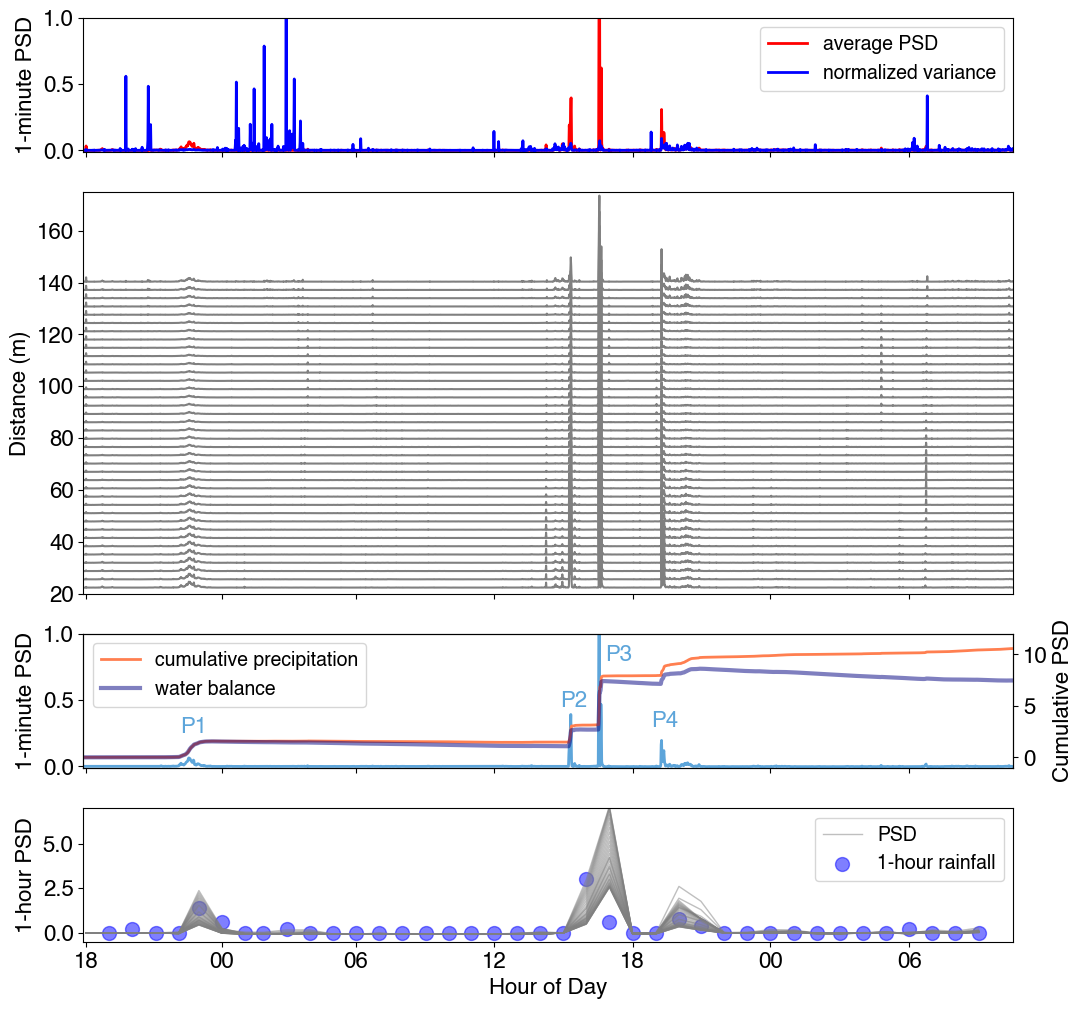

In [9]:
fig, axs = plt.subplots(4, 1, figsize=(12, 12), gridspec_kw={'height_ratios': [1, 3, 1, 1], 'hspace': 0.2}, sharex=True, tight_layout=True)

############ (A) average PSD and normalized variance
axs[0].plot(np.arange(2408), ave_psd, color='red', label='average PSD', lw=2)
axs[0].plot(np.arange(2408), np.var(int_PSD, axis=0)/(np.fabs(ave_psd)+1e-5)/4, label='normalized variance', color='blue', lw=2)
axs[0].set_ylabel("1-minute PSD")
axs[0].set_xlim(0, ave_psd.shape[-1])
axs[0].set_xticks(xax)
axs[0].set_xticklabels(hrax)
axs[0].set_ylim(-0.01, 1)
axs[0].legend(loc='upper right', fontsize=14)

############ (B) individual PSD
for ch in np.arange(7, 45):
    axs[1].plot(np.arange(2408), int_PSD[ch, :] * 20 + ch * 3.19, label=f'Ch{ch}', color='gray')
axs[1].set_ylabel("Distance (m)")
axs[1].set_xlim(0, ave_psd.shape[-1])
axs[1].set_xticks(xax)
axs[1].set_xticklabels(hrax)
axs[1].set_ylim(20, 175)

############ (C) average PSD with drainage, with non-rainfall noise removed
ave_psd_inspect = ave_psd
ave_psd_inspect[1190:1258] = 0 
ave_psd_inspect[:200] = 0 

### Incorporate drainage
decay = np.exp(-np.arange(2408)/3200)
res_diff = np.gradient(np.convolve(decay, ave_psd, mode='full')[:2408])

axs[2].plot(np.arange(2408), res_diff, lw=2, color='#5DA5DA')
axs[2].text(250,  0.25, 'P1',  color='#5DA5DA')
axs[2].text(1235, 0.45, 'P2',  color='#5DA5DA')
axs[2].text(1350, 0.80, 'P3',  color='#5DA5DA')
axs[2].text(1470, 0.30, 'P4',  color='#5DA5DA')
axs[2].set_ylabel("1-minute PSD")
axs[2].set_xlim(0, ave_psd.shape[-1])
axs[2].set_xticks(xax)
axs[2].set_xticklabels(hrax)
axs[2].set_ylim(-0.01, 1)

twinx = axs[2].twinx()
twinx.plot(np.cumsum(ave_psd), label='cumulative precipitation', lw=2, color='coral')
twinx.plot(np.cumsum(res_diff), label='water balance',lw=3, alpha=0.5, color='navy')
twinx.set_ylabel("Cumulative PSD")
twinx.set_ylim(-1, 12)
twinx.legend(loc='upper left', fontsize=14)

############ (D) hourly rainfall and PSD
int_PSD[:, 1190:1258] = 0 
int_PSD[:, :200] = 0 
for ch in np.arange(7, 45):
    hr_psd = []
    for ind in hourly_index:
        st_ind = int(ind - 60)
        ed_ind = st_ind + 60
        hr_psd.append(np.sum(int_PSD[ch, st_ind:ed_ind]))
    if ch == 7:
        axs[3].plot(hourly_index, np.array(hr_psd), color='gray', lw=1, alpha=0.5, label='PSD')
    else:
        axs[3].plot(hourly_index, np.array(hr_psd), color='gray', lw=1, alpha=0.5)

axs[3].scatter(hourly_index[1:], rain_diff, label='1-hour rainfall', color='b', marker='o', s=100, alpha=0.5)
axs[3].set_xlabel("Hour of Day")
axs[3].set_ylabel("1-hour PSD")
axs[3].set_xlim(0, ave_psd.shape[-1])
axs[3].set_ylim(-0.5, 7)
axs[3].set_xticks(xax)
axs[3].set_xticklabels(hrax)
axs[3].legend(fontsize=14)

plt.savefig(os.path.join(fig_dir, 'psd_and_rain.pdf'), dpi=300)


# Evapotranspiration

/var/folders/94/_f91r5t1277f16yl_03mnxkw0000gn/T/ipykernel_80331/1229655671.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(fig_dir, 'weather_and_ET0.pdf'), dpi=300)
/var/folders/94/_f91r5t1277f16yl_03mnxkw0000gn/T/ipykernel_80331/1229655671.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(fig_dir, 'weather_and_ET0.pdf'), dpi=300)
/Users/shiqibin/miniconda3/envs/quakeflow/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


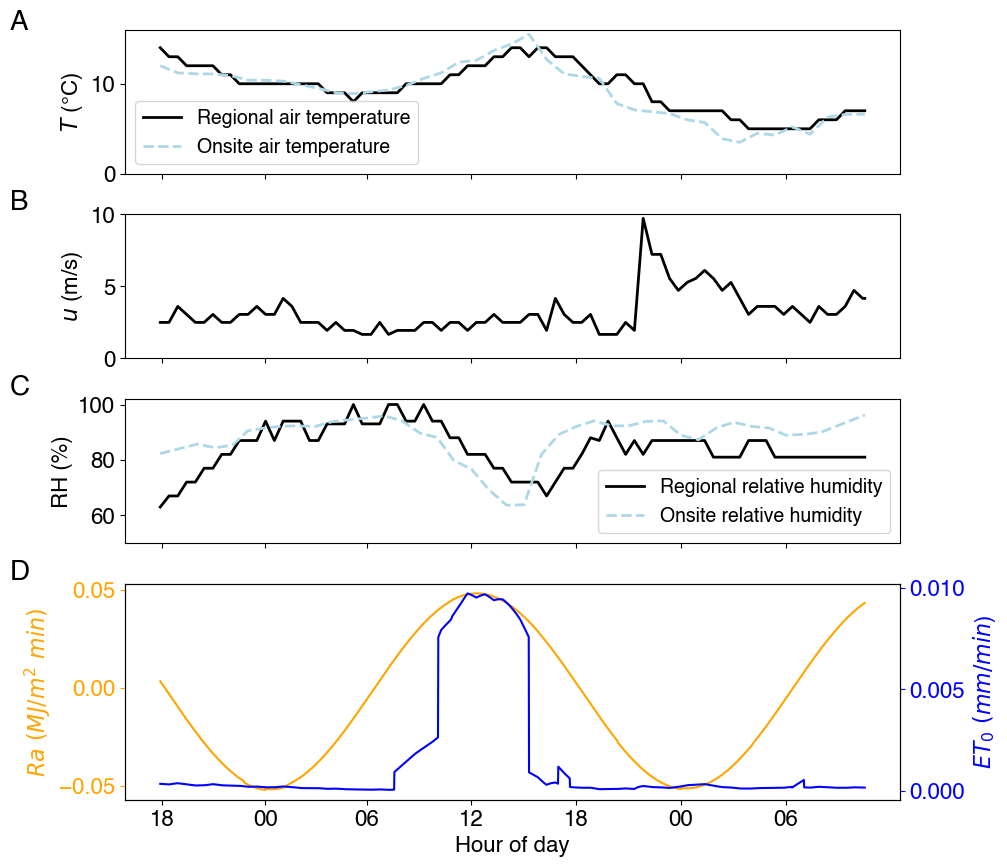

In [10]:
### get the extraterrestrial radiation
lat = 52.78
lon = -2.43
day = 76   ## 17th March
lz = 0  
time = 12.0
duration = 1.0/60  ## 1 minute
rad_a_shortterm(lat, lon, day, lz, time, duration)

rad_every_minute = np.zeros(acqu_time.shape[0])
for imin in range(0, acqu_time.shape[0]):
    day = acqu_time[imin].timetuple().tm_yday
    time = acqu_time[imin].hour + acqu_time[imin].minute/60
    rad_every_minute[imin] = rad_a_shortterm(lat, lon, day, lz, time, 1.0/60)

### get the ETo
rad = np.zeros(2408)
rad[800:950] = 0.33
rad[950:1260] = 0.99
rad[1360:1400] = 0.33
rad[2158:2200] = 0.33
rad = rad * rad_every_minute
eto_every_minute=eto_shortterm(rad, air_temp_local, wind_speed_interpolated*0.75, r_humidity)
    


######################### FIGURE
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 10), tight_layout=True, sharex=True, gridspec_kw={'height_ratios': [2, 2, 2, 3],'hspace': 0.25})

# Plot regional air temperature and air temperature on site
ax1.plot(np.arange(2408), air_temp_interpolated, label='Regional air temperature', color='k', lw=2)
ax1.plot(np.arange(2408), air_temp_local, label='Onsite air temperature', color='lightblue', linestyle='--', lw=2)
ax1.set_ylabel("$T$ (°C)")
ax1.set_ylim(0, 16)
ax1.set_xticks(xax)
ax1.set_xticklabels(hrax)
ax1.legend(fontsize=14, loc='lower left')

# Plot wind speed
ax2.plot(np.arange(2408), wind_speed_interpolated, label='wind speed', color='k', lw=2)
ax2.set_ylabel("$u$ (m/s)")
ax2.set_ylim(0, 10)
ax2.set_xticks(xax)
ax2.set_xticklabels(hrax)


# Plot humidity
ax3.plot(np.arange(2408), humidity_interpolated, label='Regional relative humidity', color='k', lw=2)
ax3.plot(np.arange(2408), interp_humidity, label='Onsite relative humidity', color='lightblue', linestyle='--', lw=2)

ax3.set_ylabel("RH (%)")
ax3.set_ylim(50, 102)
ax3.legend(fontsize=14, loc='lower right')

# Plot ETo
ax4.plot(np.arange(acqu_time.shape[0]), rad_every_minute, label='1-minute radiation', color='orange')
ax4.set_xlabel("Hour of day")
ax4.set_ylabel("$Ra~(MJ/m^{2}~min)$", color='orange')
ax4.set_xticks(xax)
ax4.set_xticklabels(hrax)
ax4.tick_params(axis='y', colors='orange')

ax5 = ax4.twinx()
ax5.plot(np.arange(acqu_time.shape[0]), eto_every_minute, label='1-minute ETo', color='blue')
ax5.set_ylabel("$ET_0~(mm/min$)", color='blue')
ax5.tick_params(axis='y', colors='blue')

fig.text(0.01, 0.88, "A", fontsize=20, fontweight='bold')
fig.text(0.01, 0.70, "B", fontsize=20, fontweight='bold')
fig.text(0.01, 0.515, "C", fontsize=20, fontweight='bold')
fig.text(0.01, 0.33, "D", fontsize=20, fontweight='bold')

plt.savefig(os.path.join(fig_dir, 'weather_and_ET0.pdf'), dpi=300)

# Model: Precipitation - Evaporation

--- Contact Analysis at ϕ = 0.5 ---
Total particles: 1000
Fraction of particles with at least one contact: 0.97
Average number of contacts per particle: 3.92
Maximum possible contacts (FCC/HCP): 12
Relative contact efficiency: 32.7%


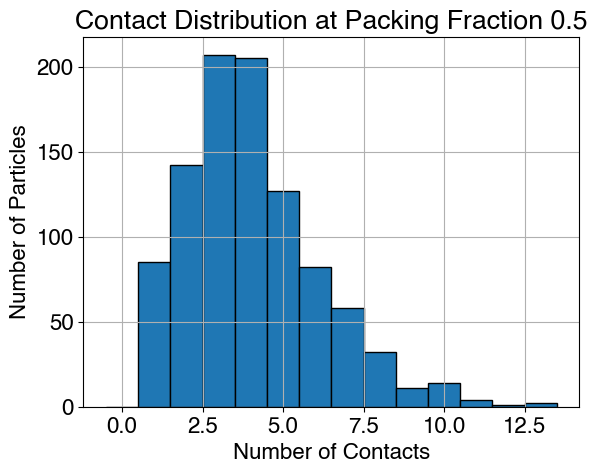

In [11]:
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt

# Parameters
n_particles = 1000             # number of particles
radius = 1.0                   # radius of each particle
max_contacts = 12             # FCC/HCP ideal contact number
packing_fraction = 0.5      # desired packing fraction

# Geometry calculations
volume_particle = (4/3) * np.pi * radius**3
total_particle_volume = n_particles * volume_particle
box_volume = total_particle_volume / packing_fraction
box_length = box_volume**(1/3)

# Generate random particle positions
positions = np.random.uniform(0, box_length, size=(n_particles, 3))

# Use KD-tree to find neighbors within 2R (touching distance)
tree = cKDTree(positions)
pairs = tree.query_pairs(r=2*radius * 1.01)  # small tolerance

# Count number of contacts per particle
contact_counts = np.zeros(n_particles, dtype=int)
for i, j in pairs:
    contact_counts[i] += 1
    contact_counts[j] += 1

# Compute stats
n_touching = np.sum(contact_counts > 0)
fraction_touching = n_touching / n_particles
avg_contacts = np.mean(contact_counts)

print(f"--- Contact Analysis at ϕ = {packing_fraction} ---")
print(f"Total particles: {n_particles}")
print(f"Fraction of particles with at least one contact: {fraction_touching:.2f}")
print(f"Average number of contacts per particle: {avg_contacts:.2f}")
print(f"Maximum possible contacts (FCC/HCP): {max_contacts}")
print(f"Relative contact efficiency: {avg_contacts / max_contacts * 100:.1f}%")

# Optional: histogram of contact numbers
plt.hist(contact_counts[contact_counts > 0], bins=np.arange(0, 15)-0.5, edgecolor='black')
plt.xlabel("Number of Contacts")
plt.ylabel("Number of Particles")
plt.title("Contact Distribution at Packing Fraction 0.5")
plt.grid(True)
plt.show()

In [ ]:
# ### other values from drainage-wetting experiments by Sakaki et al. (2010)
# tau1 = 1e6 * np.exp(1*np.power(s_history_smooth[0:800],3))  ## wetting
# tau2 = 1e7 * (1-s_history_smooth[800:1250])  ## drying
# tau3 = 1e6 * np.exp(1*np.power(s_history_smooth[1250:1900],3))  ## wetting
# tau4 = 1e7 * (1-s_history_smooth[1900:])  ## drying
# tau = np.concatenate((tau1, tau2, tau3, tau4))

### Channel 18

/var/folders/94/_f91r5t1277f16yl_03mnxkw0000gn/T/ipykernel_80331/3190531005.py:145: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


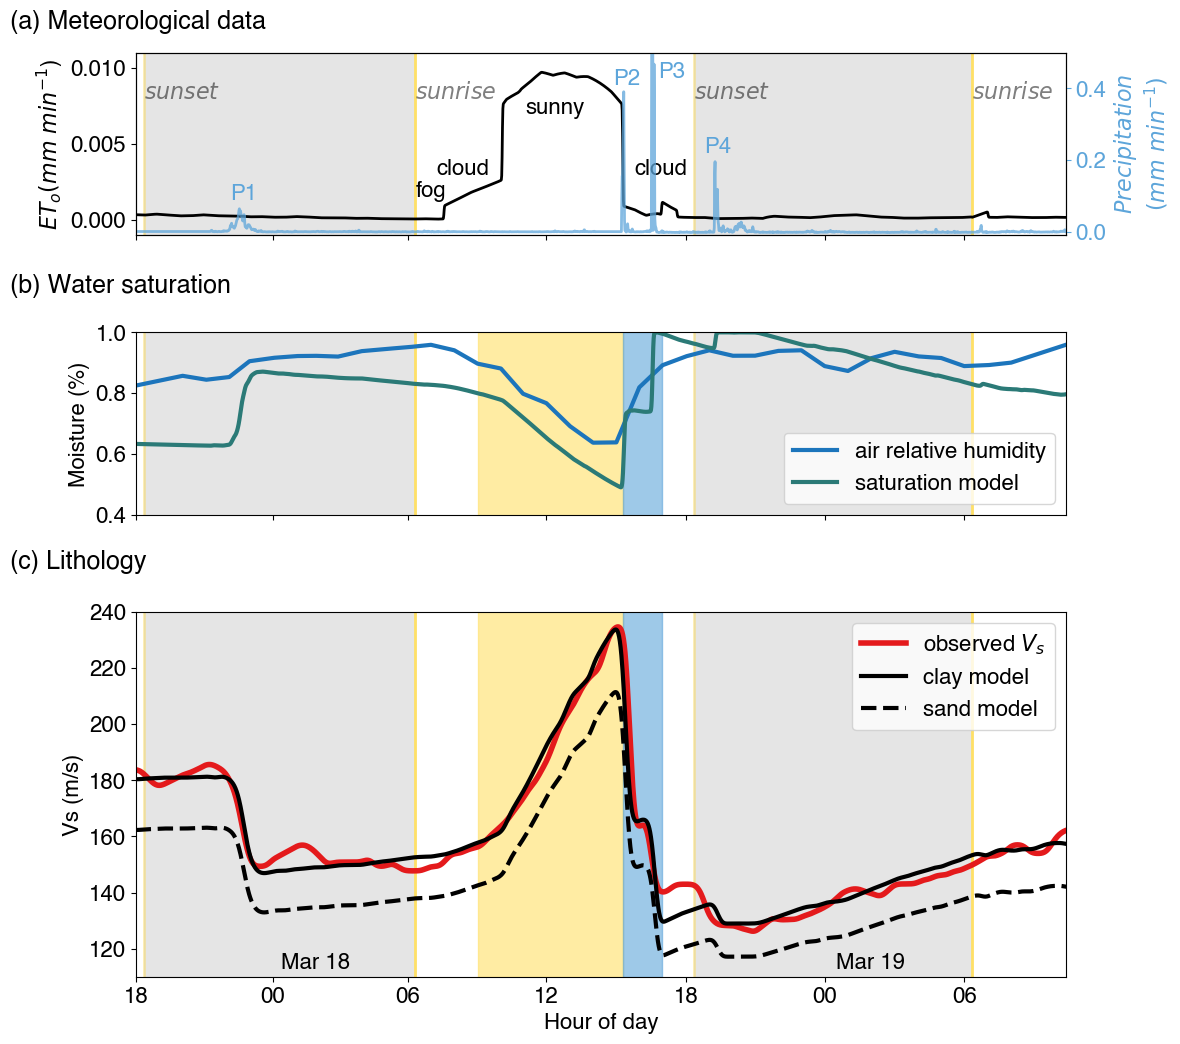

In [12]:
## Model the water balance
A_e, A_d, A_p = 1, 0, 1
bulk_density, porosity = interp_bulk_density_10cm[18]*1000, interp_porosity_10cm[18]/100
drain_dura = 3200
ini_sw_cor = 0.19
soil_dep = 12.5
dyn_type = 0
vs0=128

## radiation
rad = np.zeros(2408)
rad[800:950] = 0.33
rad[950:1260] = 0.99
rad[1360:1400] = 0.33
rad[2158:2200] = 0.33
rad = rad * rad_every_minute
eto_every_minute=eto_shortterm(rad, air_temp_local, wind_speed_interpolated*0.75, r_humidity) 

## rain
decay = np.exp(-np.arange(8000)/drain_dura)
res_psd = np.gradient(np.convolve(ave_psd, decay, mode='full')[:2408])

######################### Model hydrology
s_history = hydro0(res_psd, 0.5, interp_humidity[0]/100-ini_sw_cor, interp_temp10, 9, eto_every_minute, disturbance_index[18-6], A_p,A_e,A_d, length=2408, depth=soil_dep).get_s_history()
s_history_smooth = gaussian_filter1d(s_history, sigma=2, mode='reflect')
s_history_smooth = np.roll(s_history_smooth, 2)
s_history_smooth[0:2] = s_history_smooth[2]
s_rate = np.diff(s_history_smooth, append=s_history_smooth[-1]) / 60 ## Saturation rate, per second

######################### Model lithology
s_wr = 0.25  ## residual saturation
s=interp_humidity/100
### referecence values: 0.1 - 0.3
new_f_clay = np.minimum((1 - s_history_smooth), 0.5)
new_f_sand = np.minimum((1 - s_history_smooth), 0.5)

### capillary pressure (Sakaki et al. 2010)
dry_ind = np.where(s_rate <= 0)[0]
wet_ind = np.where(s_rate > 0)[0]
tau = np.zeros(2408)
tau[wet_ind] = 5e5 * np.exp(1*np.power(s_history_smooth[wet_ind], 5))  ## wetting
tau[dry_ind] = 1.5e10 * np.exp(0-9*s_history_smooth[dry_ind])  ## drying

### Model the shear wave velocity
vp_sand, vs_sand,   _, _, _ = litho(bulk_density, porosity, 6, new_f_sand, s_history_smooth, 0.15, tau, igore_capillary=False).get_vp_vs()
vp_clay, vs_clay,   _, _, _ = litho(bulk_density, porosity, 8, new_f_clay, s_history_smooth, s_wr, tau, igore_capillary=False).get_vp_vs()
vs_clay = np.roll(gaussian_filter1d(vs_clay, sigma=10, mode='reflect'), 10)
vs_sand = np.roll(gaussian_filter1d(vs_sand, sigma=10, mode='reflect'), 10)
vs_clay[0:10] = vs_clay[10]
vs_sand[0:10] = vs_sand[10]

### observed shear wave velocity
v_obs =gaussian_filter1d((dvv_all[18]+1)*vs0, sigma=10, mode='reflect')


######################### FIGURE
fig, (ax3, ax1, ax2) = plt.subplots(3, 1, figsize=(12, 12), tight_layout=True, gridspec_kw={'height_ratios': [1, 1, 2], 'hspace': 0.4}, sharex=True)

# Weather data plot
ax3.fill_between([27,   726], [-0.2,-0.2], [3.7,3.7], color='gray', alpha=0.2)
ax3.fill_between([1443,2158], [-0.2,-0.2], [3.7,3.7], color='gray', alpha=0.2)
ax3.axvline(x=27,   color='#FFE066', linestyle='-', lw=2, alpha=0.5)
ax3.axvline(x=726,  color='#FFE066', linestyle='-', lw=2, alpha=1)
ax3.axvline(x=1443, color='#FFE066', linestyle='-', lw=2, alpha=0.5)
ax3.axvline(x=2158, color='#FFE066', linestyle='-', lw=2, alpha=1)
ax3.text(27,   0.008, '$sunset$',  color='k', fontstyle='italic', alpha=0.5)
ax3.text(726,  0.008, '$sunrise$', color='k', fontstyle='italic', alpha=0.5)
ax3.text(1443, 0.008, '$sunset$',  color='k', fontstyle='italic', alpha=0.5)
ax3.text(2158, 0.008, '$sunrise$', color='k', fontstyle='italic', alpha=0.5)
ax3.text(726, 0.0015, 'fog',     color='k')
ax3.text(780,  0.003, 'cloud',   color='k')
ax3.text(1010,  0.007, 'sunny',  color='k')
ax3.text(1290, 0.003, 'cloud',   color='k')

eto_every_minute_smooth = gaussian_filter1d(eto_every_minute, sigma=1, mode='reflect')
ax3.plot(np.arange(2408), eto_every_minute_smooth, color='k', lw=2, label='reference ET')
ax3.set_ylabel("$ET_o (mm~min^{-1}$)", fontsize=16)
ax3.set_ylim(-0.001, 0.011)
twinx = ax3.twinx()
twinx.plot(np.arange(2408), res_psd, color='#5DA5DA', lw=2, label='rainfall rate', alpha=0.75)
twinx.tick_params(axis='y', colors='#5DA5DA')
twinx.set_ylabel("$Precipitation$\n$(mm~min^{-1})$", fontsize=16, color='#5DA5DA')
twinx.set_ylim(-0.01, 0.5)
twinx.text(250,  0.09, 'P1',  color='#5DA5DA')
twinx.text(1235, 0.41, 'P2',  color='#5DA5DA')
twinx.text(1350, 0.43, 'P3',  color='#5DA5DA')
twinx.text(1470, 0.22, 'P4',  color='#5DA5DA')
# Save eto_every_minute_smooth and res_psd into a single CSV file

data = {
    'eto_every_minute_smooth': eto_every_minute_smooth,
    'res_psd': res_psd
}

df = pd.DataFrame(data)
df.to_csv(os.path.join(data_dir, 'eto_psd.csv'), index=False)


# Water balance plot
ax1.fill_between(np.arange(2408), 0, 1, where=eto_every_minute > 0.002, color='#FFE066', alpha=0.6)
ax1.fill_between([1260,1360], [0,0], [1,1], color='#5DA5DA', alpha=0.6)
ax1.fill_between([27,   726], [0,0], [1,1], color='gray', alpha=0.2)
ax1.fill_between([1443,2158], [0,0], [1,1], color='gray', alpha=0.2)
ax1.axvline(x=27,   color='#FFE066', linestyle='-', lw=2, alpha=0.5)
ax1.axvline(x=726,  color='#FFE066', linestyle='-', lw=2, alpha=1)
ax1.axvline(x=1443, color='#FFE066', linestyle='-', lw=2, alpha=0.5)
ax1.axvline(x=2158, color='#FFE066', linestyle='-', lw=2, alpha=1)

ax1.plot(np.arange(2408), s, label='air relative humidity', color='#1c75bc', lw=3)
ax1.plot(np.arange(2408), s_history_smooth, label='saturation model', lw=3, color='#2b7a77')
ax1.set_ylim(0.4, 1)
ax1.set_xlim(10, 2400)
ax1.set_ylabel("Moisture (%)", fontsize=16)
ax1.legend(loc='lower right')


# Lithology plot
ax2.fill_between(np.arange(2408), 110, 260, where=eto_every_minute > 0.002, color='#FFE066', alpha=0.6)
ax2.fill_between([1260,1360], [110,110], [260,260], color='#5DA5DA', alpha=0.6)
ax2.fill_between([27,   726], [110,110], [260,260], color='gray', alpha=0.2)
ax2.fill_between([1443,2158], [110,110], [260,260], color='gray', alpha=0.2)
ax2.set_ylim(110, 240)
ax2.axvline(x=27,   color='#FFE066', linestyle='-', lw=2, alpha=0.5)
ax2.axvline(x=726,  color='#FFE066', linestyle='-', lw=2, alpha=1)
ax2.axvline(x=1443, color='#FFE066', linestyle='-', lw=2, alpha=0.5)
ax2.axvline(x=2158, color='#FFE066', linestyle='-', lw=2, alpha=1)
ax2.text(Ind6hrs[1] + 20, 113, 'Mar 18', color='k')
ax2.text(Ind6hrs[5] + 30, 113, 'Mar 19', color='k')

ax2.plot(np.arange(2408), v_obs, label='observed $V_s$', lw=4, color='#e41a1c')
ax2.plot(np.arange(2408), vs_clay, label='clay model', color='k', lw=3)
ax2.plot(np.arange(2408), vs_sand, label='sand model', color='k', lw=3, ls='--')
ax2.set_xlabel("Hour of day", fontsize=16)
ax2.set_ylabel("Vs (m/s)", fontsize=16)
ax2.set_xticks(xax)
ax2.set_xticklabels([t.strftime('%H') for t in tax], fontsize=16)
ax2.legend(loc='upper right')



fig.text(0.02, 0.9, '(a) Meteorological data', fontsize=18)
fig.text(0.02, 0.68, '(b) Water saturation', fontsize=18)
fig.text(0.02, 0.45, '(c) Lithology', fontsize=18)

plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'soil_model.pdf'), bbox_inches='tight', dpi=300)

### Uncertatinty of dynamic coefficient, drainage rate

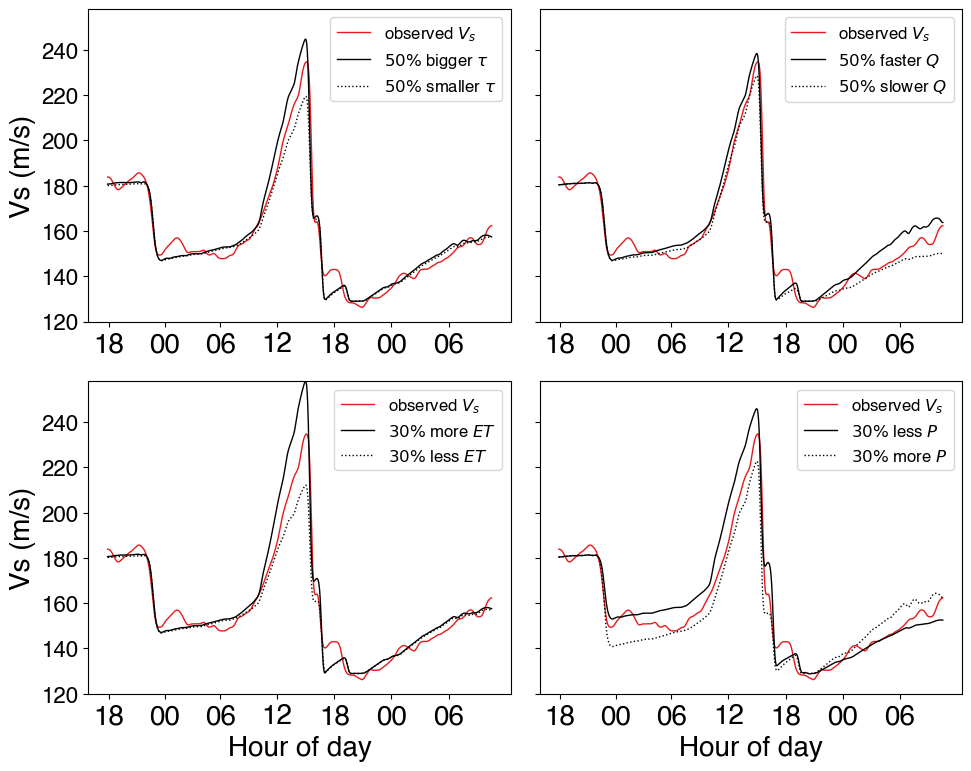

In [26]:
## Model the water balance
A_e, A_d, A_p = 1, 0, 1
bulk_density, porosity = interp_bulk_density_10cm[18]*1000, interp_porosity_10cm[18]/100
drain_dura = 3200
ini_sw_cor = 0.19
soil_dep = 12.5
dyn_type = 0
vs0=128

## radiation
rad = np.zeros(2408)
rad[800:950] = 0.33
rad[950:1260] = 0.99
rad[1360:1400] = 0.33
rad[2158:2200] = 0.33
rad = rad * rad_every_minute
eto_every_minute=eto_shortterm(rad, air_temp_local, wind_speed_interpolated*0.75, r_humidity) 

## rain
decay = np.exp(-np.arange(8000)/drain_dura)
res_psd = np.gradient(np.convolve(ave_psd, decay, mode='full')[:2408])

######################### Model hydrology
s_history = hydro0(res_psd, 0.5, interp_humidity[0]/100-ini_sw_cor, interp_temp10, 9, eto_every_minute, disturbance_index[18-6], A_p,A_e,A_d, length=2408, depth=soil_dep).get_s_history()
s_history_smooth = gaussian_filter1d(s_history, sigma=2, mode='reflect')
s_history_smooth = np.roll(s_history_smooth, 2)
s_history_smooth[0:2] = s_history_smooth[2]
s_rate = np.diff(s_history_smooth, append=s_history_smooth[-1]) / 60 ## Saturation rate, per second

######################### uncertainty of dynamic coefficients
s=interp_humidity/100
### referecence values: 0.1 - 0.3
new_f_clay = np.minimum((1 - s_history_smooth), 0.5)
dry_ind = np.where(s_rate <= 0)[0]
wet_ind = np.where(s_rate > 0)[0]

### capillary pressure (Sakaki et al. 2010)
tau = np.zeros(2408)
tau[wet_ind] = 5e5 * np.exp(1*np.power(s_history_smooth[wet_ind], 5))  ## wetting
tau[dry_ind] = 1.5e10 * np.exp(0-9*s_history_smooth[dry_ind]) * 0.5 ## drying
vp_clay1, vs_clay1,   _, _, _ = litho(bulk_density, porosity, 8, new_f_clay, s_history_smooth, s_wr, tau, igore_capillary=False).get_vp_vs()
vs_clay1 = np.roll(gaussian_filter1d(vs_clay1, sigma=10, mode='reflect'), 10)
vs_clay1[0:10] = vs_clay1[10]

tau = np.zeros(2408)
tau[wet_ind] = 5e5 * np.exp(1*np.power(s_history_smooth[wet_ind], 5))  ## wetting
tau[dry_ind] = 1.5e10 * np.exp(0-9*s_history_smooth[dry_ind]) * 1.5  ## drying
vp_clay2, vs_clay2,   _, _, _ = litho(bulk_density, porosity, 8, new_f_clay, s_history_smooth, s_wr, tau, igore_capillary=False).get_vp_vs()
vs_clay2 = np.roll(gaussian_filter1d(vs_clay2, sigma=10, mode='reflect'), 10)
vs_clay2[0:10] = vs_clay2[10]

######################### uncertainty of drainage rate
drain_dura1 = 3200 / 1.5
drain_dura2 = 3200 / 0.5
decay1 = np.exp(-np.arange(8000)/drain_dura1)
res_psd1 = np.gradient(np.convolve(ave_psd, decay1, mode='full')[:2408])
decay2 = np.exp(-np.arange(8000)/drain_dura2)
res_psd2 = np.gradient(np.convolve(ave_psd, decay2, mode='full')[:2408])

s_history1 = hydro0(res_psd1, 0.5, interp_humidity[0]/100-ini_sw_cor, interp_temp10, 9, eto_every_minute, disturbance_index[18-6], A_p,A_e,A_d, length=2408, depth=soil_dep).get_s_history()
s_history_smooth1 = gaussian_filter1d(s_history1, sigma=2, mode='reflect')
s_history_smooth1 = np.roll(s_history_smooth1, 2)
s_history_smooth1[0:2] = s_history_smooth1[2]
s_history2 = hydro0(res_psd2, 0.5, interp_humidity[0]/100-ini_sw_cor, interp_temp10, 9, eto_every_minute, disturbance_index[18-6], A_p,A_e,A_d, length=2408, depth=soil_dep).get_s_history()
s_history_smooth2 = gaussian_filter1d(s_history2, sigma=2, mode='reflect')
s_history_smooth2 = np.roll(s_history_smooth2, 2)
s_history_smooth2[0:2] = s_history_smooth2[2]

tau = np.zeros(2408)
tau[wet_ind] = 5e5 * np.exp(1*np.power(s_history_smooth1[wet_ind], 5))  ## wetting
tau[dry_ind] = 1.5e10 * np.exp(0-9*s_history_smooth1[dry_ind]) ## drying

vp_clay3, vs_clay3,   _, _, _ = litho(bulk_density, porosity, 8, new_f_clay, s_history_smooth1, s_wr, tau, igore_capillary=False).get_vp_vs()
vs_clay3 = np.roll(gaussian_filter1d(vs_clay3, sigma=10, mode='reflect'), 10)
vs_clay3[0:10] = vs_clay3[10]

tau = np.zeros(2408)
tau[wet_ind] = 5e5 * np.exp(1*np.power(s_history_smooth2[wet_ind], 5))  ## wetting
tau[dry_ind] = 1.5e10 * np.exp(0-9*s_history_smooth2[dry_ind]) ## drying

vp_clay4, vs_clay4,   _, _, _ = litho(bulk_density, porosity, 8, new_f_clay, s_history_smooth2, s_wr, tau, igore_capillary=False).get_vp_vs()
vs_clay4 = np.roll(gaussian_filter1d(vs_clay4, sigma=10, mode='reflect'), 10)
vs_clay4[0:10] = vs_clay4[10]


######################### uncertainty of ET
s_history3 = hydro0(res_psd, 0.5, interp_humidity[0]/100-ini_sw_cor, interp_temp10, 9, eto_every_minute*0.7, disturbance_index[18-6], A_p,A_e,A_d, length=2408, depth=soil_dep).get_s_history()
s_history_smooth3 = gaussian_filter1d(s_history3, sigma=2, mode='reflect')
s_history_smooth3 = np.roll(s_history_smooth3, 2)
s_history_smooth3[0:2] = s_history_smooth3[2]
s_history4 = hydro0(res_psd, 0.5, interp_humidity[0]/100-ini_sw_cor, interp_temp10, 9, eto_every_minute*1.3, disturbance_index[18-6], A_p,A_e,A_d, length=2408, depth=soil_dep).get_s_history()
s_history_smooth4 = gaussian_filter1d(s_history4, sigma=2, mode='reflect')
s_history_smooth4 = np.roll(s_history_smooth4, 2)
s_history_smooth4[0:2] = s_history_smooth4[2]

tau = np.zeros(2408)
tau[wet_ind] = 5e5 * np.exp(1*np.power(s_history_smooth3[wet_ind], 5))  ## wetting
tau[dry_ind] = 1.5e10 * np.exp(0-9*s_history_smooth3[dry_ind]) ## drying

vp_clay5, vs_clay5,   _, _, _ = litho(bulk_density, porosity, 8, new_f_clay, s_history_smooth3, s_wr, tau, igore_capillary=False).get_vp_vs()
vs_clay5 = np.roll(gaussian_filter1d(vs_clay5, sigma=10, mode='reflect'), 10)
vs_clay5[0:10] = vs_clay5[10]

tau = np.zeros(2408)
tau[wet_ind] = 5e5 * np.exp(1*np.power(s_history_smooth4[wet_ind], 5))  ## wetting
tau[dry_ind] = 1.5e10 * np.exp(0-9*s_history_smooth4[dry_ind]) ## drying

vp_clay6, vs_clay6,   _, _, _ = litho(bulk_density, porosity, 8, new_f_clay, s_history_smooth4, s_wr, tau, igore_capillary=False).get_vp_vs()
vs_clay6 = np.roll(gaussian_filter1d(vs_clay6, sigma=10, mode='reflect'), 10)
vs_clay6[0:10] = vs_clay6[10]


######################### uncertainty of Precipitation
res_psd1 = np.gradient(np.convolve(ave_psd*0.5, decay, mode='full')[:2408])
res_psd2 = np.gradient(np.convolve(ave_psd*1.5, decay, mode='full')[:2408])

s_history1 = hydro0(res_psd1, 0.5, interp_humidity[0]/100-ini_sw_cor, interp_temp10, 9, eto_every_minute, disturbance_index[18-6], A_p,A_e,A_d, length=2408, depth=soil_dep).get_s_history()
s_history_smooth1 = gaussian_filter1d(s_history1, sigma=2, mode='reflect')
s_history_smooth1 = np.roll(s_history_smooth1, 2)
s_history_smooth1[0:2] = s_history_smooth1[2]
s_history2 = hydro0(res_psd2, 0.5, interp_humidity[0]/100-ini_sw_cor, interp_temp10, 9, eto_every_minute, disturbance_index[18-6], A_p,A_e,A_d, length=2408, depth=soil_dep).get_s_history()
s_history_smooth2 = gaussian_filter1d(s_history2, sigma=2, mode='reflect')
s_history_smooth2 = np.roll(s_history_smooth2, 2)
s_history_smooth2[0:2] = s_history_smooth2[2]

tau = np.zeros(2408)
tau[wet_ind] = 5e5 * np.exp(1*np.power(s_history_smooth1[wet_ind], 5))  ## wetting
tau[dry_ind] = 1.5e10 * np.exp(0-9*s_history_smooth1[dry_ind]) ## drying

vp_clay7, vs_clay7,   _, _, _ = litho(bulk_density, porosity, 8, new_f_clay, s_history_smooth1, s_wr, tau, igore_capillary=False).get_vp_vs()
vs_clay7 = np.roll(gaussian_filter1d(vs_clay7, sigma=10, mode='reflect'), 10)
vs_clay7[0:10] = vs_clay7[10]

tau = np.zeros(2408)
tau[wet_ind] = 5e5 * np.exp(1*np.power(s_history_smooth2[wet_ind], 5))  ## wetting
tau[dry_ind] = 1.5e10 * np.exp(0-9*s_history_smooth2[dry_ind]) ## drying

vp_clay8, vs_clay8,   _, _, _ = litho(bulk_density, porosity, 8, new_f_clay, s_history_smooth2, s_wr, tau, igore_capillary=False).get_vp_vs()
vs_clay8 = np.roll(gaussian_filter1d(vs_clay8, sigma=10, mode='reflect'), 10)
vs_clay8[0:10] = vs_clay8[10]


### observed shear wave velocity
v_obs =gaussian_filter1d((dvv_all[18]+1)*vs0, sigma=10, mode='reflect')


######################### FIGURE
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8), tight_layout=True, sharey=True)

ax1.set_ylim(120, 258)
ax1.plot(np.arange(2408), v_obs, label='observed $V_s$', lw=1, color='#e41a1c')
ax1.plot(np.arange(2408), vs_clay2, label=r'$50\%$ bigger $\tau$', color='k', lw=1, ls='-')
ax1.plot(np.arange(2408), vs_clay1, label=r'$50\%$ smaller $\tau$', color='k', lw=1, ls=':')
ax1.set_ylabel("Vs (m/s)", fontsize=20)
ax1.set_xticks(xax)
ax1.set_xticklabels([t.strftime('%H') for t in tax], fontsize=20)

ax1.legend(fontsize=12, loc='upper right')

ax2.set_ylim(120, 258)
ax2.plot(np.arange(2408), v_obs, label='observed $V_s$', lw=1, color='#e41a1c')
ax2.plot(np.arange(2408), vs_clay3, label='$50\%$ faster $Q$', color='k', lw=1, ls='-')
ax2.plot(np.arange(2408), vs_clay4, label='$50\%$ slower $Q$', color='k', lw=1, ls=':')
ax2.set_xticks(xax)
ax2.set_xticklabels([t.strftime('%H') for t in tax], fontsize=20)

ax2.legend(fontsize=12, loc='upper right')

ax3.set_ylim(120, 258)
ax3.plot(np.arange(2408), v_obs, label='observed $V_s$', lw=1, color='#e41a1c')
ax3.plot(np.arange(2408), vs_clay6, label='$30\%$ more $ET$', color='k', lw=1, ls='-')
ax3.plot(np.arange(2408), vs_clay5, label='$30\%$ less $ET$', color='k', lw=1, ls=':')
ax3.set_xlabel("Hour of day", fontsize=20)
ax3.set_ylabel("Vs (m/s)", fontsize=20)
ax3.set_xticks(xax)
ax3.set_xticklabels([t.strftime('%H') for t in tax], fontsize=20)

ax3.legend(fontsize=12, loc='upper right')

ax4.set_ylim(120, 258)
ax4.plot(np.arange(2408), v_obs, label='observed $V_s$', lw=1, color='#e41a1c')
ax4.plot(np.arange(2408), vs_clay7, label='$30\%$ less $P$', color='k', lw=1, ls='-')
ax4.plot(np.arange(2408), vs_clay8, label='$30\%$ more $P$', color='k', lw=1, ls=':')
ax4.set_xlabel("Hour of day", fontsize=20)
ax4.set_xticks(xax)
ax4.set_xticklabels([t.strftime('%H') for t in tax], fontsize=20)

ax4.legend(fontsize=12, loc='upper right')


plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'uncertainty.pdf'), bbox_inches='tight', dpi=300)

In [14]:
3200 / 1.5

2133.3333333333335

### Merge ch 18 and 33

/var/folders/94/_f91r5t1277f16yl_03mnxkw0000gn/T/ipykernel_51766/1235136783.py:189: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


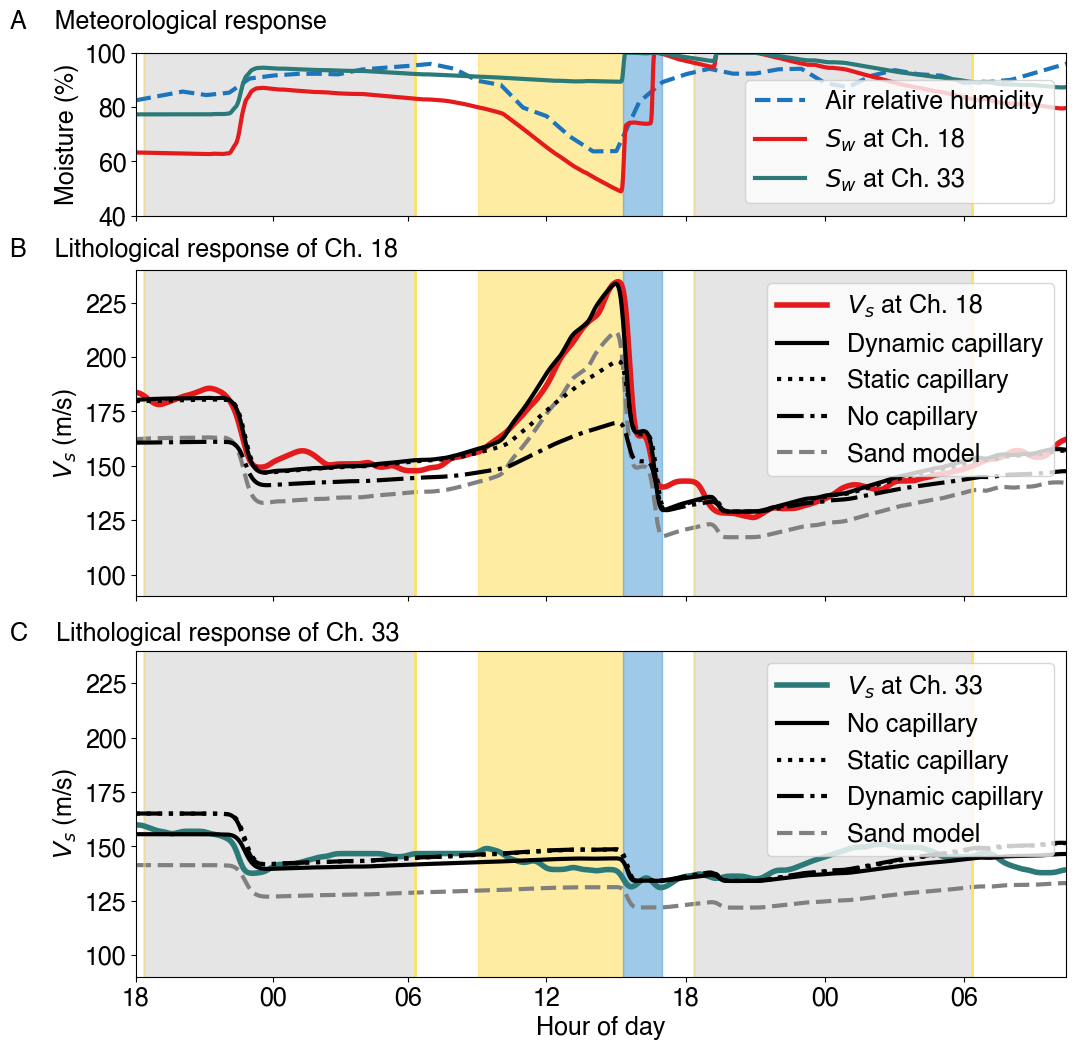

In [29]:
## radiation
rad = np.zeros(2408)
rad[800:950] = 0.33
rad[950:1260] = 0.99
rad[1360:1400] = 0.33
rad[2158:2200] = 0.33
rad = rad * rad_every_minute
eto_every_minute=eto_shortterm(rad, air_temp_local, wind_speed_interpolated*0.75, r_humidity) 

## rain
decay = np.exp(-np.arange(8000)/drain_dura)
res_psd = np.gradient(np.convolve(ave_psd, decay, mode='full')[:2408])

s_wr = 0.25  ## residual saturation
s=interp_humidity/100


####################################################### channel 18
## Model the water balance
A_e, A_d, A_p = 1, 0, 1
bulk_density, porosity = interp_bulk_density_10cm[18]*1000, interp_porosity_10cm[18]/100
drain_dura = 3200
ini_sw_cor = 0.19
soil_dep = 12.5
dyn_type = 0
vs0=128

######################### Model hydrology
s_history = hydro0(res_psd, 0.5, interp_humidity[0]/100-ini_sw_cor, interp_temp10, 9, 
                   eto_every_minute, disturbance_index[18-6], 
                   A_p,A_e,A_d, length=2408, depth=soil_dep).get_s_history()
s_history_smooth = gaussian_filter1d(s_history, sigma=2, mode='reflect')
s_history_smooth_18 = np.roll(s_history_smooth, 2)
s_history_smooth_18[0:2] = s_history_smooth_18[2]
s_rate = np.diff(s_history_smooth_18, append=s_history_smooth_18[-1]) / 60 ## Saturation rate, per second

######################### Model lithology
### referecence values: 0.1 - 0.3
new_f_clay = np.minimum((1 - s_history_smooth_18), 0.5)
new_f_sand = np.minimum((1 - s_history_smooth_18), 0.5)

### capillary pressure (Sakaki et al. 2010)
dry_ind = np.where(s_rate <= 0)[0]
wet_ind = np.where(s_rate > 0)[0]
tau = np.zeros(2408)
tau[wet_ind] = 5e5 * np.exp(1*np.power(s_history_smooth_18[wet_ind], 5))  ## wetting
tau[dry_ind] = 1.5e10 * np.exp(0-9*s_history_smooth_18[dry_ind])  ## drying

### Model the shear wave velocity
vp_clay, vs_clay,   _, _, _ = litho(bulk_density, porosity, 8, new_f_clay, s_history_smooth_18, s_wr, tau, igore_capillary=False).get_vp_vs()
vp_sand, vs_sand,   _, _, _ = litho(bulk_density, porosity, 6, new_f_sand, s_history_smooth_18, 0.15, tau, igore_capillary=False).get_vp_vs()
vs_clay_18 = np.roll(gaussian_filter1d(vs_clay, sigma=10, mode='reflect'), 10)
vs_sand_18 = np.roll(gaussian_filter1d(vs_sand, sigma=10, mode='reflect'), 10)
vs_clay_18[0:10] = vs_clay_18[10]
vs_sand_18[0:10] = vs_sand_18[10]

_, vs_clay_static,   _, _, _ = litho(bulk_density, porosity, 8, new_f_clay, s_history_smooth_18, s_wr, 0, igore_capillary=False).get_vp_vs()
_, vs_clay_nocapi,   _, _, _ = litho(bulk_density, porosity, 8, new_f_clay, s_history_smooth_18, s_wr, 0, igore_capillary=True).get_vp_vs()
vs_clay_static_18 = np.roll(gaussian_filter1d(vs_clay_static, sigma=10, mode='reflect'), 10)
vs_clay_nocapi_18 = np.roll(gaussian_filter1d(vs_clay_nocapi, sigma=10, mode='reflect'), 10)
vs_clay_static_18[0:10] = vs_clay_static_18[10]
vs_clay_nocapi_18[0:10] = vs_clay_nocapi_18[10]

### observed shear wave velocity
v_obs_18 =gaussian_filter1d((dvv_all[18]+1)*vs0, sigma=10, mode='reflect')


####################################################### channel 33
## Model the water balance
A_e, A_d, A_p = 0, 0, 1
bulk_density, porosity = interp_bulk_density_10cm[33]*1000, interp_porosity_10cm[33]/100
drain_dura = 3200
ini_sw_cor = 0.05
soil_dep = 18
vs0=136

######################### Model hydrology
s_history = hydro0(res_psd, 0.5, interp_humidity[0]/100-ini_sw_cor, interp_temp10, 9, 
                   eto_every_minute, disturbance_index[33-6], 
                   A_p,A_e,A_d, length=2408, depth=soil_dep).get_s_history()
s_history_smooth = gaussian_filter1d(s_history, sigma=2, mode='reflect')
s_history_smooth_33 = np.roll(s_history_smooth, 2)
s_history_smooth_33[0:2] = s_history_smooth_33[2]
s_rate = np.diff(s_history_smooth_33) / 60 ## Saturation rate, per second

######################### Model lithology
### referecence values: 0.1 - 0.3
new_f_clay = np.minimum((1 - s_history_smooth_33), 0.4)
new_f_sand = np.minimum((1 - s_history_smooth_33), 0.4)

### capillary pressure (Sakaki et al. 2010)
dry_ind = np.where(s_rate <= 0)[0]
wet_ind = np.where(s_rate > 0)[0]
tau = np.zeros(2408)
tau[wet_ind] = 5e5 * np.exp(1*np.power(s_history_smooth_33[wet_ind],5))  ## wetting
tau[dry_ind] = 1.5e10 * np.exp(0-9*s_history_smooth_33[dry_ind])  ## drying

### Model the shear wave velocity
vp_clay, vs_clay,   _, _, _ = litho(bulk_density, porosity, 8, new_f_clay, s_history_smooth_33, s_wr, tau, igore_capillary=True).get_vp_vs()
vp_sand, vs_sand,   _, _, _ = litho(bulk_density, porosity, 6, new_f_sand, s_history_smooth_33, 0.15, tau, igore_capillary=True).get_vp_vs()
vs_clay_33 = np.roll(gaussian_filter1d(vs_clay, sigma=10, mode='reflect'), 10)
vs_sand_33 = np.roll(gaussian_filter1d(vs_sand, sigma=10, mode='reflect'), 10)
vs_clay_33[0:10] = vs_clay[10]
vs_sand_33[0:10] = vs_sand[10]

_, vs_clay_static,   _, _, _ = litho(bulk_density, porosity, 8, new_f_clay, s_history_smooth_33, s_wr, 0, igore_capillary=False).get_vp_vs()
_, vs_clay_dyncap,   _, _, _ = litho(bulk_density, porosity, 8, new_f_clay, s_history_smooth_33, s_wr, tau, igore_capillary=False).get_vp_vs()
vs_clay_static_33 = np.roll(gaussian_filter1d(vs_clay_static, sigma=10, mode='reflect'), 10)
vs_clay_dyncap_33 = np.roll(gaussian_filter1d(vs_clay_dyncap, sigma=10, mode='reflect'), 10)
vs_clay_static_33[0:10] = vs_clay_static_33[10]
vs_clay_dyncap_33[0:10] = vs_clay_dyncap_33[10]

### observed shear wave velocity
v_obs_33 =gaussian_filter1d((dvv_all[33]+1)*vs0, sigma=10, mode='reflect')


######################### FIGURE
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), tight_layout=True, gridspec_kw={'height_ratios': [1, 2, 2], 'hspace': 0.2}, sharex=True)

# Water balance plot
ax1.fill_between(np.arange(2408), 0, 1, where=eto_every_minute > 0.002, color='#FFE066', alpha=0.6)
ax1.fill_between([1260,1360], [0,0], [1,1], color='#5DA5DA', alpha=0.6)
ax1.fill_between([27,   726], [0,0], [1,1], color='gray', alpha=0.2)
ax1.fill_between([1443,2158], [0,0], [1,1], color='gray', alpha=0.2)
ax1.axvline(x=27,   color='#FFE066', linestyle='-', lw=2, alpha=0.5)
ax1.axvline(x=726,  color='#FFE066', linestyle='-', lw=2, alpha=1)
ax1.axvline(x=1443, color='#FFE066', linestyle='-', lw=2, alpha=0.5)
ax1.axvline(x=2158, color='#FFE066', linestyle='-', lw=2, alpha=1)

ax1.plot(np.arange(2408), s, label='Air relative humidity', color='#1c75bc', lw=3, linestyle='--')
ax1.plot(np.arange(2408), s_history_smooth_18, label='$S_w$ at Ch. 18', lw=3, color='#e41a1c')
ax1.plot(np.arange(2408), s_history_smooth_33, label='$S_w$ at Ch. 33', lw=3, color='#2b7a77')
ax1.set_ylim(0.4, 1)
ax1.set_xlim(10, 2400)
ax1.set_yticks(np.arange(0.4, 1.1, 0.2))
ax1.set_yticklabels(np.arange(40, 110, 20), fontsize=18)
ax1.set_ylabel("Moisture (%)", fontsize=18)
ax1.legend(loc='lower right')


# Lithology 18
ax2.fill_between(np.arange(2408), 0, 260, where=eto_every_minute > 0.002, color='#FFE066', alpha=0.6)
ax2.fill_between([1260,1360], [0,0], [260,260], color='#5DA5DA', alpha=0.6)
ax2.fill_between([27,   726], [0,0], [260,260], color='gray', alpha=0.2)
ax2.fill_between([1443,2158], [0,0], [260,260], color='gray', alpha=0.2)
ax2.set_ylim(90, 240)
ax2.axvline(x=27,   color='#FFE066', linestyle='-', lw=2, alpha=0.5)
ax2.axvline(x=726,  color='#FFE066', linestyle='-', lw=2, alpha=1)
ax2.axvline(x=1443, color='#FFE066', linestyle='-', lw=2, alpha=0.5)
ax2.axvline(x=2158, color='#FFE066', linestyle='-', lw=2, alpha=1)

ax2.plot(np.arange(2408), v_obs_18, label='$V_s$ at Ch. 18', lw=4, color='#e41a1c')
ax2.plot(np.arange(2408), vs_clay_18, label='Dynamic capillary', color='k', lw=3)
ax2.plot(np.arange(2408), vs_clay_static_18, label='Static capillary', color='k', lw=3, ls=':')
ax2.plot(np.arange(2408), vs_clay_nocapi_18, label='No capillary', color='k', lw=3, ls='-.')
ax2.plot(np.arange(2408), vs_sand_18, label='Sand model', color='gray', lw=3, ls='--', zorder=1)
ax2.set_ylabel("$V_s$ (m/s)", fontsize=18)
ax2.legend(loc='upper right')

# Lithology 33
ax3.fill_between(np.arange(2408), 0, 260, where=eto_every_minute > 0.002, color='#FFE066', alpha=0.6)
ax3.fill_between([1260,1360], [0,0], [260,260], color='#5DA5DA', alpha=0.6)
ax3.fill_between([27,   726], [0,0], [260,260], color='gray', alpha=0.2)
ax3.fill_between([1443,2158], [0,0], [260,260], color='gray', alpha=0.2)
ax3.set_ylim(90, 240)
ax3.axvline(x=27,   color='#FFE066', linestyle='-', lw=2, alpha=0.5)
ax3.axvline(x=726,  color='#FFE066', linestyle='-', lw=2, alpha=1)
ax3.axvline(x=1443, color='#FFE066', linestyle='-', lw=2, alpha=0.5)
ax3.axvline(x=2158, color='#FFE066', linestyle='-', lw=2, alpha=1)

ax3.plot(np.arange(2408), v_obs_33, label='$V_s$ at Ch. 33', lw=4, color='#2b7a77')
ax3.plot(np.arange(2408), vs_clay_33, label='No capillary', color='k', lw=3)
ax3.plot(np.arange(2408), vs_clay_static_33, label='Static capillary', color='k', lw=3, ls=':')
ax3.plot(np.arange(2408), vs_clay_dyncap_33, label='Dynamic capillary', color='k', lw=3, ls='-.')
ax3.plot(np.arange(2408), vs_sand_33, label='Sand model', color='gray', lw=3, ls='--', zorder=1)
ax3.set_xlabel("Hour of day", fontsize=18)
ax3.set_ylabel("$V_s$ (m/s)", fontsize=18)
ax3.set_xticks(xax)
ax3.set_xticklabels([t.strftime('%H') for t in tax], fontsize=18)
ax3.legend(loc='upper right')




fig.text(0.02, 0.90, 'A    Meteorological response', fontsize=18)
fig.text(0.02, 0.71, 'B    Lithological response of Ch. 18', fontsize=18)
fig.text(0.02, 0.39, 'C    Lithological response of Ch. 33', fontsize=18)

plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'soil_model.pdf'), bbox_inches='tight', dpi=300)

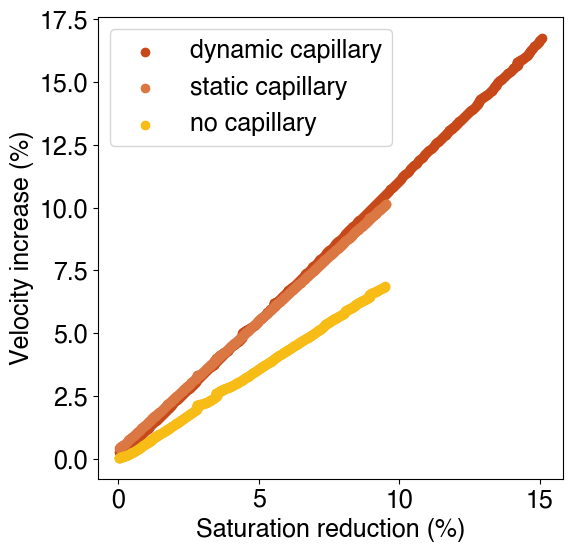

In [27]:
plt.figure(figsize=(6, 6))
plt.scatter(100*(1-s_history_smooth_18[1600:2100]), 100*(vs_clay_18[1600:2100]/128.7-1), color='#c74819', label='dynamic capillary')
plt.scatter(100*(1-s_history_smooth[1600:2100]), 100*(vs_clay_static[1600:2100]/133.5-1), color='#db7742', label='static capillary')
plt.scatter(100*(1-s_history_smooth_33[1600:2100]), 100*(vs_clay_33[1600:2100]/134-1), color='#f8bc17', label='no capillary')

plt.xlabel('Saturation reduction (%)')
plt.ylabel('Velocity increase (%)')
plt.legend()

/var/folders/94/_f91r5t1277f16yl_03mnxkw0000gn/T/ipykernel_37060/2178111962.py:142: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


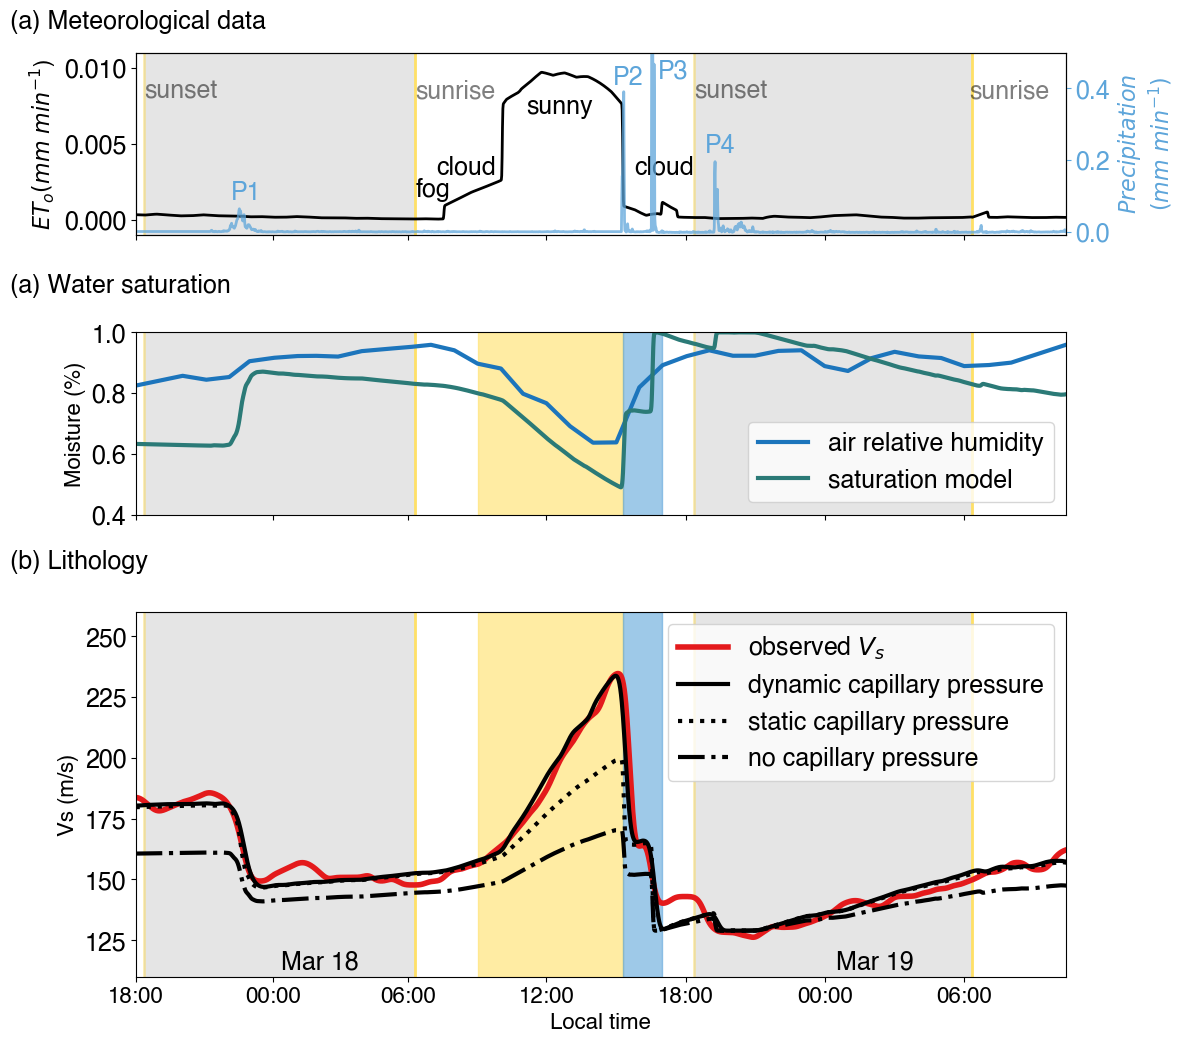

In [18]:
## Model the water balance
A_e, A_d, A_p = 1, 0, 1
bulk_density, porosity = interp_bulk_density_10cm[18]*1000, interp_porosity_10cm[18]/100
drain_dura = 3200
ini_sw_cor = 0.19
soil_dep = 12.5
dyn_type = 0
vs0=128

## radiation
rad = np.zeros(2408)
rad[800:950] = 0.33
rad[950:1260] = 0.99
rad[1360:1400] = 0.33
rad[2158:2200] = 0.33
rad = rad * rad_every_minute
eto_every_minute=eto_shortterm(rad, air_temp_local, wind_speed_interpolated*0.75, r_humidity) 

## rain
decay = np.exp(-np.arange(8000)/drain_dura)
res_psd = np.gradient(np.convolve(ave_psd, decay, mode='full')[:2408])

######################### Model hydrology
s_history = hydro0(res_psd, 0.5, interp_humidity[0]/100-ini_sw_cor, interp_temp10, 9, eto_every_minute, disturbance_index[18-6], A_p,A_e,A_d, length=2408, depth=soil_dep).get_s_history()
s_history_smooth = gaussian_filter1d(s_history, sigma=2, mode='reflect')
s_history_smooth = np.roll(s_history_smooth, 2)
s_history_smooth[0:2] = s_history_smooth[2]
s_rate = np.diff(s_history_smooth) / 60 ## Saturation rate, per second

######################### Model lithology
s_wr = 0.25  ## residual saturation
s=interp_humidity/100
### referecence values: 0.1 - 0.3
new_f_clay = np.minimum((1 - s_history_smooth), 0.5)
new_f_sand = np.minimum((1 - s_history_smooth), 0.5)

### capillary pressure (Sakaki et al. 2010)
dry_ind = np.where(s_rate <= 0)[0]
wet_ind = np.where(s_rate > 0)[0]
tau = np.zeros(2408)
tau[wet_ind] = 5e5 * np.exp(1*np.power(s_history_smooth[wet_ind],5))  ## wetting
tau[dry_ind] = 1.5e10 * np.exp(0-9*s_history_smooth[dry_ind])  ## drying

### Model the shear wave velocity
vp_clay, vs_clay,   _, _, _ = litho(bulk_density, porosity, 8, new_f_clay, s_history_smooth, s_wr, tau, igore_capillary=False).get_vp_vs()
vs_clay = np.roll(gaussian_filter1d(vs_clay, sigma=10, mode='reflect'), 10)
vs_clay[0:10] = vs_clay[10]

vp_clay_static, vs_clay_static,   _, _, _ = litho(bulk_density, porosity, 8, new_f_clay, s_history_smooth, s_wr, 0, igore_capillary=False).get_vp_vs()
vp_clay_static = np.roll(gaussian_filter1d(vp_clay_static, sigma=10, mode='reflect'), 10)
vp_clay_static[0:10] = vp_clay_static[10]

vp_clay_nocapi, vs_clay_nocapi,   _, _, _ = litho(bulk_density, porosity, 8, new_f_clay, s_history_smooth, s_wr, 0, igore_capillary=True).get_vp_vs()
vp_clay_nocapi = np.roll(gaussian_filter1d(vp_clay_nocapi, sigma=10, mode='reflect'), 10)
vp_clay_nocapi[0:10] = vp_clay_nocapi[10]

### observed shear wave velocity
v_obs =gaussian_filter1d((dvv_all[18]+1)*vs0, sigma=10, mode='reflect')


######################### FIGURE
fig, (ax3, ax1, ax2) = plt.subplots(3, 1, figsize=(12, 12), tight_layout=True, gridspec_kw={'height_ratios': [1, 1, 2], 'hspace': 0.4}, sharex=True)

# Weather data plot
ax3.fill_between([27,   726], [-0.2,-0.2], [3.7,3.7], color='gray', alpha=0.2)
ax3.fill_between([1443,2158], [-0.2,-0.2], [3.7,3.7], color='gray', alpha=0.2)
ax3.axvline(x=27,   color='#FFE066', linestyle='-', lw=2, alpha=0.5)
ax3.axvline(x=726,  color='#FFE066', linestyle='-', lw=2, alpha=1)
ax3.axvline(x=1443, color='#FFE066', linestyle='-', lw=2, alpha=0.5)
ax3.axvline(x=2158, color='#FFE066', linestyle='-', lw=2, alpha=1)
ax3.text(27,   0.008, 'sunset',  color='k', fontstyle='italic', alpha=0.5)
ax3.text(726,  0.008, 'sunrise', color='k', fontstyle='italic', alpha=0.5)
ax3.text(1443, 0.008, 'sunset',  color='k', fontstyle='italic', alpha=0.5)
ax3.text(2150, 0.008, 'sunrise', color='k', fontstyle='italic', alpha=0.5)
ax3.text(726, 0.0015, 'fog',     color='k')
ax3.text(780,  0.003, 'cloud',   color='k')
ax3.text(1010, 0.007, 'sunny',   color='k')
ax3.text(1290, 0.003, 'cloud',   color='k')

eto_every_minute_smooth = gaussian_filter1d(eto_every_minute, sigma=1, mode='reflect')
ax3.plot(np.arange(2408), eto_every_minute_smooth, color='k', lw=2, label='reference ET')
ax3.set_ylabel("$ET_o (mm~min^{-1}$)", fontsize=16)
ax3.set_ylim(-0.001, 0.011)
twinx = ax3.twinx()
twinx.plot(np.arange(2408), res_psd, color='#5DA5DA', lw=2, label='rainfall rate', alpha=0.75)
twinx.tick_params(axis='y', colors='#5DA5DA')
twinx.set_ylabel("$Precipitation$\n$(mm~min^{-1})$", fontsize=16, color='#5DA5DA')
twinx.set_ylim(-0.01, 0.5)
twinx.text(250,  0.09, 'P1',  color='#5DA5DA')
twinx.text(1235, 0.41, 'P2',  color='#5DA5DA')
twinx.text(1350, 0.43, 'P3',  color='#5DA5DA')
twinx.text(1470, 0.22, 'P4',  color='#5DA5DA')


# Water balance plot
ax1.fill_between(np.arange(2408), 0, 1, where=eto_every_minute > 0.002, color='#FFE066', alpha=0.6)
ax1.fill_between([1260,1360], [0,0], [1,1], color='#5DA5DA', alpha=0.6)
ax1.fill_between([27,   726], [0,0], [1,1], color='gray', alpha=0.2)
ax1.fill_between([1443,2158], [0,0], [1,1], color='gray', alpha=0.2)
ax1.axvline(x=27,   color='#FFE066', linestyle='-', lw=2, alpha=0.5)
ax1.axvline(x=726,  color='#FFE066', linestyle='-', lw=2, alpha=1)
ax1.axvline(x=1443, color='#FFE066', linestyle='-', lw=2, alpha=0.5)
ax1.axvline(x=2158, color='#FFE066', linestyle='-', lw=2, alpha=1)

ax1.plot(np.arange(2408), s, label='air relative humidity', color='#1c75bc', lw=3)
ax1.plot(np.arange(2408), s_history_smooth, label='saturation model', lw=3, color='#2b7a77')
ax1.set_ylim(0.4, 1)
ax1.set_xlim(10, 2400)
ax1.set_ylabel("Moisture (%)", fontsize=16)
ax1.legend(loc='lower right')


# Lithology plot
ax2.fill_between(np.arange(2408), 110, 260, where=eto_every_minute > 0.002, color='#FFE066', alpha=0.6)
ax2.fill_between([1260,1360], [110,110], [260,260], color='#5DA5DA', alpha=0.6)
ax2.fill_between([27,   726], [110,110], [260,260], color='gray', alpha=0.2)
ax2.fill_between([1443,2158], [110,110], [260,260], color='gray', alpha=0.2)
ax2.set_ylim(110, 260)
ax2.axvline(x=27,   color='#FFE066', linestyle='-', lw=2, alpha=0.5)
ax2.axvline(x=726,  color='#FFE066', linestyle='-', lw=2, alpha=1)
ax2.axvline(x=1443, color='#FFE066', linestyle='-', lw=2, alpha=0.5)
ax2.axvline(x=2158, color='#FFE066', linestyle='-', lw=2, alpha=1)
ax2.text(Ind6hrs[1] + 20, 113, 'Mar 18', color='k')
ax2.text(Ind6hrs[5] + 30, 113, 'Mar 19', color='k')

ax2.plot(np.arange(2408), v_obs,          label='observed $V_s$', color='#e41a1c', lw=4,)
ax2.plot(np.arange(2408), vs_clay,        label='dynamic capillary pressure', color='k', lw=3)
ax2.plot(np.arange(2408), vs_clay_static, label='static capillary pressure', color='k', lw=3, ls=':')
ax2.plot(np.arange(2408), vs_clay_nocapi, label='no capillary pressure', color='k', lw=3, ls='-.')
ax2.set_xlabel("Local time", fontsize=16)
ax2.set_ylabel("Vs (m/s)", fontsize=16)
ax2.set_xticks(xax)
ax2.set_xticklabels([t.strftime('%H:%M') for t in tax], fontsize=16)
ax2.legend(loc='upper right')



fig.text(0.02, 0.9, '(a) Meteorological data', fontsize=18)
fig.text(0.02, 0.68, '(a) Water saturation', fontsize=18)
fig.text(0.02, 0.45, '(b) Lithology', fontsize=18)

plt.tight_layout()
plt.show()

### Channel 44

/var/folders/94/_f91r5t1277f16yl_03mnxkw0000gn/T/ipykernel_37060/3190933890.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(fig_dir, 'soil_model_44.pdf'), dpi=300)
/var/folders/94/_f91r5t1277f16yl_03mnxkw0000gn/T/ipykernel_37060/3190933890.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(fig_dir, 'soil_model_44.pdf'), dpi=300)
/Users/shiqibin/miniconda3/envs/quakeflow/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


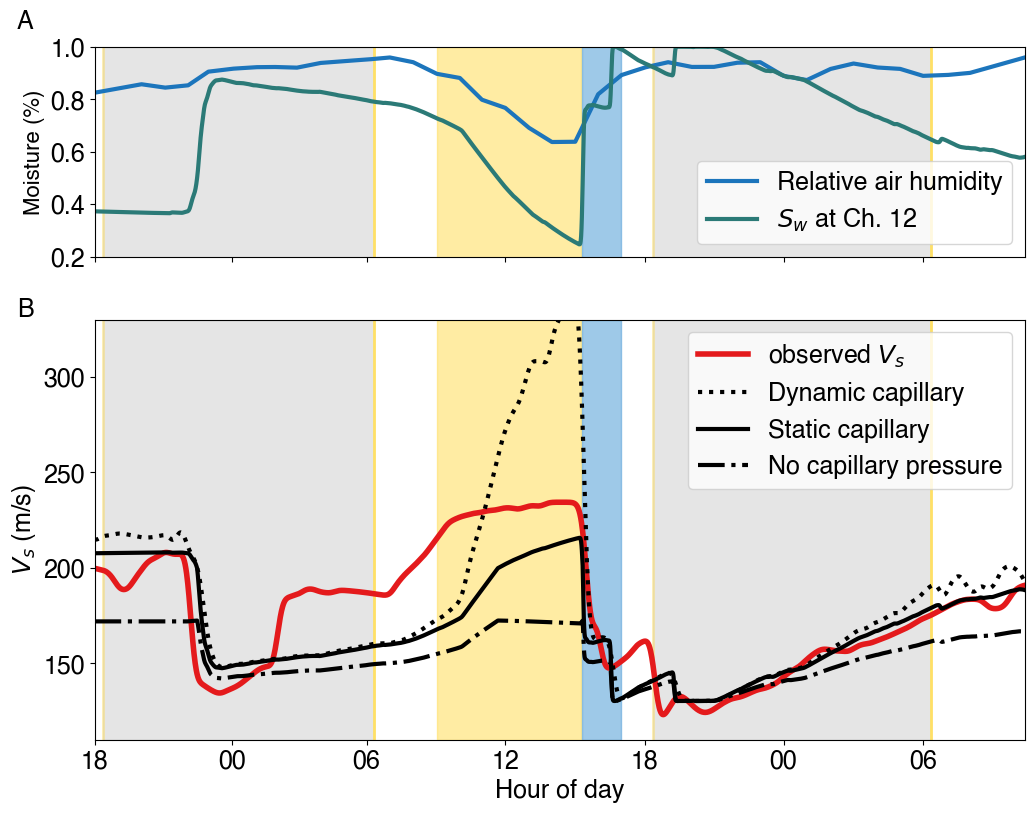

In [23]:
## Model the water balance
A_e, A_d, A_p = 1, 0, 1
bulk_density, porosity = 2, poro10[44]/100
# drain_dura =7000
# ini_sw_cor = 0.25
# soil_dep = 1.6

vs0=vs_clay10[44]-10
drain_dura = 3200
ini_sw_cor = 0.45
soil_dep = 6

## radiation
rad = np.zeros(2408)
rad[800:950] = 0.33
rad[950:1260] = 0.99
rad[1360:1400] = 0.33
rad[2158:2200] = 0.33
rad = rad * rad_every_minute
eto_every_minute=eto_shortterm(rad, air_temp_local, wind_speed_interpolated*0.75, r_humidity) 

## rain
decay = np.exp(-np.arange(8000)/drain_dura)
res_psd = np.gradient(np.convolve(ave_psd, decay, mode='full')[:2408])

######################### Model hydrology
s_history = hydro0(res_psd, 0.5, interp_humidity[0]/100-ini_sw_cor, interp_temp10, 9, 
                   eto_every_minute, disturbance_index[44-6], A_p,A_e,A_d, 
                   length=2408, depth=soil_dep).get_s_history()
s_history_smooth = gaussian_filter1d(s_history, sigma=2, mode='reflect')
s_history_smooth = np.roll(s_history_smooth, 2)
s_history_smooth[0:2] = s_history_smooth[2]
s_rate = np.diff(s_history_smooth) / 60 ## Saturation rate, per second

######################### Model lithology
s_wr = 0.25  ## residual saturation
s=interp_humidity/100
### referecence values: 0.1 - 0.3
new_f_clay = np.minimum((1 - s_history_smooth), 0.5)
new_f_sand = np.minimum((1 - s_history_smooth), 0.5)

### capillary pressure (Sakaki et al. 2010)
dry_ind = np.where(s_rate <= 0)[0]
wet_ind = np.where(s_rate > 0)[0]
tau = np.zeros(2408)
tau[wet_ind] = 5e5 * np.exp(1*np.power(s_history_smooth[wet_ind],5))  ## wetting
tau[dry_ind] = 1.5e10 * np.exp(0-9*s_history_smooth[dry_ind])  ## drying

### Model the shear wave velocity
vp_clay, vs_clay,   _, _, _ = litho(bulk_density, porosity, 8, new_f_clay, s_history_smooth, s_wr, tau, igore_capillary=False).get_vp_vs()
vs_clay = np.roll(gaussian_filter1d(vs_clay, sigma=10, mode='reflect'), 10)
vs_clay[0:10] = vs_clay[10]

vp_clay_static, vs_clay_static,   _, _, _ = litho(bulk_density, porosity, 8, new_f_clay, s_history_smooth, s_wr, 0, igore_capillary=False).get_vp_vs()
vp_clay_static = np.roll(gaussian_filter1d(vp_clay_static, sigma=10, mode='reflect'), 10)
vp_clay_static[0:10] = vp_clay_static[10]

vp_clay_nocapi, vs_clay_nocapi,   _, _, _ = litho(bulk_density, porosity, 8, new_f_clay, s_history_smooth, s_wr, 0, igore_capillary=True).get_vp_vs()
vp_clay_nocapi = np.roll(gaussian_filter1d(vp_clay_nocapi, sigma=10, mode='reflect'), 10)
vp_clay_nocapi[0:10] = vp_clay_nocapi[10]

### observed shear wave velocity
v_obs =gaussian_filter1d((dvv_all[44]+1)*vs0, sigma=10, mode='reflect')



######################### FIGURE
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9), tight_layout=True, gridspec_kw={'height_ratios': [1, 2], 'hspace': 0.2}, sharex=True)


# Water balance plot
ax1.fill_between(np.arange(2408), 0, 1, where=eto_every_minute > 0.002, color='#FFE066', alpha=0.6)
ax1.fill_between([1260,1360], [0,0], [1,1], color='#5DA5DA', alpha=0.6)
ax1.fill_between([27,   726], [0,0], [1,1], color='gray', alpha=0.2)
ax1.fill_between([1443,2158], [0,0], [1,1], color='gray', alpha=0.2)
ax1.axvline(x=27,   color='#FFE066', linestyle='-', lw=2, alpha=0.5)
ax1.axvline(x=726,  color='#FFE066', linestyle='-', lw=2, alpha=1)
ax1.axvline(x=1443, color='#FFE066', linestyle='-', lw=2, alpha=0.5)
ax1.axvline(x=2158, color='#FFE066', linestyle='-', lw=2, alpha=1)

ax1.plot(np.arange(2408), s, label='Relative air humidity', color='#1c75bc', lw=3)
ax1.plot(np.arange(2408), s_history_smooth, label='$S_w$ at Ch. 12', lw=3, color='#2b7a77')
ax1.set_ylim(0.2, 1)
ax1.set_xlim(10, 2400)
ax1.set_ylabel("Moisture (%)", fontsize=16)
ax1.legend(loc='lower right')


# Lithology plot
ax2.fill_between(np.arange(2408), 110, 330, where=eto_every_minute > 0.002, color='#FFE066', alpha=0.6)
ax2.fill_between([1260,1360], [110,110], [330,330], color='#5DA5DA', alpha=0.6)
ax2.fill_between([27,   726], [110,110], [330,330], color='gray', alpha=0.2)
ax2.fill_between([1443,2158], [110,110], [330,330], color='gray', alpha=0.2)
ax2.set_ylim(110, 330)
ax2.axvline(x=27,   color='#FFE066', linestyle='-', lw=2, alpha=0.5)
ax2.axvline(x=726,  color='#FFE066', linestyle='-', lw=2, alpha=1)
ax2.axvline(x=1443, color='#FFE066', linestyle='-', lw=2, alpha=0.5)
ax2.axvline(x=2158, color='#FFE066', linestyle='-', lw=2, alpha=1)

ax2.plot(np.arange(2408), v_obs,          label='observed $V_s$', color='#e41a1c', lw=4,)
ax2.plot(np.arange(2408), vs_clay,        label='Dynamic capillary', color='k', lw=3, ls=':')
ax2.plot(np.arange(2408), vs_clay_static, label='Static capillary', color='k', lw=3)
ax2.plot(np.arange(2408), vs_clay_nocapi, label='No capillary pressure', color='k', lw=3, ls='-.')
ax2.set_xlabel("Hour of day", fontsize=18)
ax2.set_ylabel("$V_s$ (m/s)", fontsize=18)
ax2.set_xticks(xax)
ax2.set_xticklabels([t.strftime('%H') for t in tax], fontsize=18)
ax2.legend(loc='upper right')

fig.text(0.06, 0.9, 'A')
fig.text(0.06, 0.58, 'B')

plt.savefig(os.path.join(fig_dir, 'soil_model_44.pdf'), dpi=300)

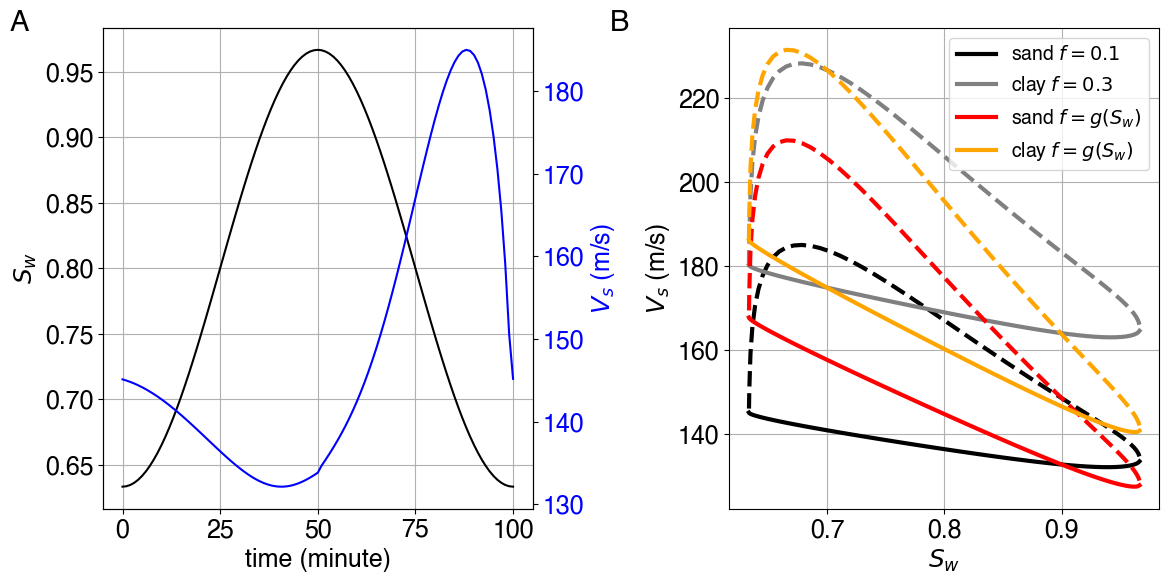

In [24]:
def symmetric_function(length):
    """
    Generate a cosine-shaped symmetric function array of given length.
    The function is symmetric around its center.

    Parameters:
    length (int): Length of the array.

    Returns:
    numpy.ndarray: Symmetric array.
    """
    if length % 2 == 0:
        raise ValueError("Length must be odd to ensure symmetry.")
    center = length // 2
    x = np.linspace(-np.pi, np.pi, length)
    return np.cos(x)



# Plot the symmetric function and velocity as subfigures
length = 101  # Example length
half_length = length // 2
symmetric_array = symmetric_function(length) / 6 + 0.8

# Prepare data for velocity plot
# tau1 = 2e6 * np.exp(2*np.power(symmetric_array[0:half_length+1], 3))  # wetting
# tau2 = 1e7 * (1 - symmetric_array[half_length+1:])  # drying

tau1 = 5e5 * np.exp(1*np.power(symmetric_array[0:half_length+1],5))  ## wetting
tau2 = 1.5e10 * np.exp(0-9* symmetric_array[half_length+1:])  ## drying

tau = np.concatenate((tau1, tau2))

scale_factor = (symmetric_array+1)/2 * 3.5 - 0.6
new_f = 1-symmetric_array

bulk_density, porosity = 1400, 0.47
vp_sand, vs_sand, _, _, _ = litho(bulk_density, porosity, 6, 0.1, symmetric_array[:], 0.15, tau).get_vp_vs()
vp_clay, vs_clay, _, _, _ = litho(bulk_density, porosity, 8, 0.3, symmetric_array[:], 0.25, tau).get_vp_vs()
vp_sand1, vs_sand1, _, _, _ = litho(bulk_density, porosity, 6, new_f, symmetric_array[:], 0.15, tau).get_vp_vs()
vp_clay1, vs_clay1, _, _, _ = litho(bulk_density, porosity, 8, new_f, symmetric_array[:], 0.25, tau).get_vp_vs()



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)

# Subfigure 1: Symmetric Function
ax1.plot(symmetric_array, label="water content", color="k")
twinx = ax1.twinx()
twinx.plot(vs_sand, label="velocity", color="b", linestyle="-")
twinx.set_ylabel("$V_s$ (m/s)", color="b")
twinx.tick_params(axis='y', labelcolor="b")
ax1.set_xlabel("time (minute)")
ax1.set_ylabel("$S_w$")
# ax1.legend()
ax1.grid(True)



# Subfigure 2: Velocity
ax2.plot(symmetric_array[:half_length], vs_sand[:half_length], label="sand $f=0.1$", color="k", lw=3)
ax2.plot(symmetric_array[half_length+1:], vs_sand[half_length+1:], color="k", lw=3, ls="--")
ax2.plot(symmetric_array[:half_length], vs_clay[:half_length], label="clay $f=0.3$", color="gray", lw=3)
ax2.plot(symmetric_array[half_length+1:], vs_clay[half_length+1:], color="gray", lw=3, ls="--")
ax2.plot(symmetric_array[:half_length], vs_sand1[:half_length], label="sand $f=g(S_w)$", color="red", lw=3)
ax2.plot(symmetric_array[half_length+1:], vs_sand1[half_length+1:],  color="red", lw=3, ls="--")
ax2.plot(symmetric_array[:half_length], vs_clay1[:half_length], label="clay $f=g(S_w)$", color="orange", lw=3)
ax2.plot(symmetric_array[half_length+1:], vs_clay1[half_length+1:],  color="orange", lw=3, ls="--")
ax2.set_xlabel("$S_w$")
ax2.set_ylabel("$V_s$ (m/s)")
ax2.legend(fontsize=14)
ax2.grid(True)

fig.text(0.02, 0.95, 'A', fontsize=21)
fig.text(0.52, 0.95, 'B', fontsize=21)

plt.savefig(os.path.join(fig_dir, 'hysteresis.pdf'), dpi=300)

### Forward model for all, different dyn_type

In [22]:
vs_clay10 = np.array([142.98042876, 141.7399632 , 141.25853689, 143.09166934,
       146.87407675, 145.08693113, 141.49427135, 142.88800759,
       141.41885551, 141.42203385, 143.41283866, 143.58782889,
       143.06172297, 141.27297887, 138.52041523, 142.52095061,
       145.02856046, 143.49609569, 135.60574036, 138.67469303,
       142.56797963, 142.478887  , 136.14358864, 136.04753178,
       139.81108453, 142.862936  , 141.81713984, 142.17128864,
       144.21741646, 145.54322446, 141.8344042 , 140.1744006 ,
       142.96280622, 140.99990104, 140.28721177, 141.29288689,
       142.85020057, 141.30376561, 141.36034643, 141.5858231 ,
       135.67345622, 138.80249099, 143.60731635, 144.88768551,
       139.41526622, 140.244049  , 144.20654966, 144.43239118,
       140.94211175, 139.45980423])

poro10 = np.array([50.80014696, 52.31826595, 52.89262716, 50.661249  , 45.64750938,
        48.08904842, 52.61240069, 50.91519562, 52.70226116, 52.69847808,
        50.25762011, 50.03605673, 50.69868633, 52.87551505, 56.0110229 ,
        51.36900035, 48.16653726, 50.15234997, 59.07504009, 55.84175124,
        51.31113353, 51.42068899, 58.52815175, 58.62641837, 54.57171179,
        50.94635075, 52.22543266, 51.79671702, 49.22915482, 47.47848489,
        52.20463702, 54.1568533 , 50.82210856, 53.19786084, 54.02715009,
        52.85191442, 50.96216746, 52.83901207, 52.77183986, 52.50304601,
        59.00663049, 55.70097024, 50.01131042, 48.35298238, 55.01877462,
        54.07682592, 49.243213  , 48.95008896, 53.2657473 , 54.96872365])

v_evap = np.array([5.5208273e-02, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.1250151e-02,
       4.1065987e-02, 1.0274613e-01, 0.0000000e+00, 3.3997262e-01,
       3.3997262e-01, 4.3042290e-01, 4.3520138e-01, 8.0023909e-01,
       9.7847342e-01, 1.0000000e+00, 9.1855502e-01, 9.2936296e-04,
       3.5079471e-03, 2.6044345e-02, 0.0000000e+00, 6.3046157e-02,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       1.5981111e-01, 2.6303351e-01, 1.9842978e-01, 0.0000000e+00,
       1.4065059e-02, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       4.3555728e-01, 4.3448395e-01, 4.4805741e-01, 3.3717990e-01,
       0.0000000e+00, 0.0000000e+00])

types = np.where(v_evap > 0.7, 0, np.where(v_evap > 0.28, 1, 2))

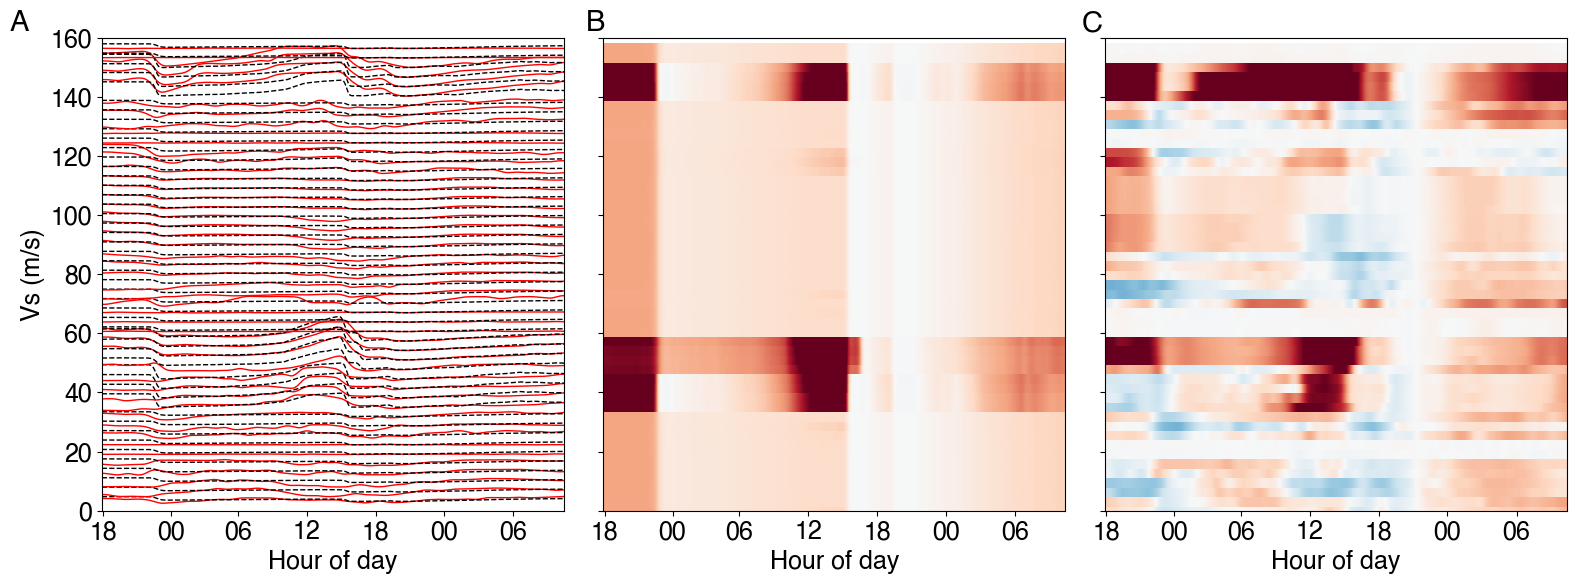

In [ ]:
vs_ref = []
dvv_model = []

fig, (ax2, ax1, ax3) = plt.subplots(1,3, figsize=(16, 6), sharey=True, gridspec_kw={'width_ratios': [1, 1, 1]}, tight_layout=True)


for iloc in np.arange(0,50):
    ## Model the water balance
    A_e, A_d, A_p = 1, 0, 1
    porosity = poro10[iloc]/100
    dyn_type = types[iloc]
    vs0 = vs_clay10[iloc]

    ## radiation
    rad = np.zeros(2408)
    rad[800:950] = 0.33
    rad[950:1260] = 0.99
    rad[1360:1400] = 0.33
    rad[2158:2200] = 0.33
    rad = rad * rad_every_minute
    eto_every_minute=eto_shortterm(rad, air_temp_local, wind_speed_interpolated*0.75, r_humidity) 


    ######################### Model hydrology
    if dyn_type == 0:
        ini_sw_cor = 0.19
        soil_dep = 12.5
        drain_dura = 3200
        ## rain
        decay = np.exp(-np.arange(8000)/drain_dura)
        res_psd = np.gradient(np.convolve(ave_psd, decay, mode='full')[:2408])
        s_history = hydro0(res_psd, 0.5, interp_humidity[0]/100-ini_sw_cor, interp_temp10, 9, eto_every_minute, v_evap[iloc], A_p,A_e,A_d, length=2408, depth=soil_dep).get_s_history()
    elif dyn_type == 1:
        ini_sw_cor = 0.35
        soil_dep = 3
        drain_dura = 7000
        ## rain
        decay = np.exp(-np.arange(8000)/drain_dura)
        res_psd = np.gradient(np.convolve(ave_psd, decay, mode='full')[:2408])
        s_history = hydro0(res_psd, 0.5, interp_humidity[0]/100-ini_sw_cor, interp_temp10, 9, eto_every_minute, v_evap[iloc], A_p,A_e,A_d, length=2408, depth=soil_dep).get_s_history()
    else:
        ini_sw_cor = 0.05
        soil_dep = 18
        drain_dura = 3200
        ## rain
        decay = np.exp(-np.arange(8000)/drain_dura)
        res_psd = np.gradient(np.convolve(ave_psd, decay, mode='full')[:2408])
        s_history = hydro0(res_psd, 0.5, interp_humidity[0]/100-ini_sw_cor, interp_temp10, 9, eto_every_minute, v_evap[iloc], A_p,A_e,A_d, length=2408, depth=soil_dep).get_s_history()
    s_history_smooth = gaussian_filter1d(s_history, sigma=5, mode='reflect')
    s_history_smooth = np.roll(s_history_smooth, 10)
    s_history_smooth[0:10] = s_history_smooth[10]
    s_rate = np.diff(s_history_smooth) / 60 ## Saturation rate, per second

    ######################### Model lithology
    s_wr = 0.25  ## residual saturation
    s=interp_humidity/100
    ### referecence values: 0.1 - 0.3
    new_f_clay = np.minimum((1 - s_history_smooth), 0.4)
    new_f_sand = np.minimum((1 - s_history_smooth), 0.4)

    ### capillary pressure (Sakaki et al. 2010)
    dry_ind = np.where(s_rate <= 0)[0]
    wet_ind = np.where(s_rate > 0)[0]
    tau = np.zeros(2408)
    tau[wet_ind] = 5e5 * np.exp(1*np.power(s_history_smooth[wet_ind],5))  ## wetting
    tau[dry_ind] = 1.5e10 * np.exp(0-8*s_history_smooth[dry_ind])  ## drying

    ### Model the shear wave velocity
    if dyn_type == 0:
        vp_clay, vs_clay,   _, _, _ = litho(bulk_density, porosity, 8, new_f_clay, s_history_smooth, s_wr, tau, igore_capillary=False).get_vp_vs()
    elif dyn_type == 1:
        vp_clay, vs_clay,   _, _, _ = litho(bulk_density, porosity, 8, new_f_clay, s_history_smooth, s_wr, 0, igore_capillary=False).get_vp_vs()
    else:
        vp_clay, vs_clay,   _, _, _ = litho(bulk_density, porosity, 8, new_f_clay, s_history_smooth, s_wr, 0, igore_capillary=True).get_vp_vs()
    vs_clay = gaussian_filter1d(vs_clay, sigma=10, mode='reflect')

    # if dyn_type == 0:
    #     vs_correction = 0
    # elif dyn_type == 1:
    #     vs_correction = 0
    # else:
    #     vs_clay_ref = np.mean(vs_clay[150:210])
    #     vs_ref.append(vs_clay_ref)
    #     vs_correction = vs_clay_ref - np.mean((dvv_all[iloc, 150:210]+1)*vs0)

    # ### observed shear wave velocity
    # v_obs =gaussian_filter1d((dvv_all[iloc]+1)*vs0, sigma=10, mode='reflect')

    dvv_clay = vs_clay / np.mean(vs_clay[1500:1575]) - 1
    dvv_model.append(dvv_clay)

    ### Plot the water balance
    if iloc > 0:
        ax2.plot(np.arange(2408), 10*dvv_all[iloc] + iloc*3.19 , label='Vs ', lw=1, color='r')
        ax2.plot(np.arange(2408), 10*dvv_clay+iloc*3.19, label=f'channel {i}', color='k', lw=1, ls='--')
ax2.set_ylabel("Vs (m/s)")
ax2.set_xticks(xax)
ax2.set_xticklabels([t.strftime('%H') for t in tax])
ax2.set_xlabel("Hour of day")
ax2.set_ylim(0, 160)
ax2.set_xlim(0, 2400)

dvv_model = np.array(dvv_model)
ax1.pcolor(np.arange(2408), np.arange(50)*3.19, dvv_model, shading='auto', vmin=-0.4, vmax=0.4, cmap = 'RdBu_r')
ax1.set_ylim(0, 160)
ax1.set_xlim(0, 2400)
ax1.set_xlabel("Hour of day")
ax1.set_xticks(xax)
ax1.set_xticklabels([t.strftime('%H') for t in tax])

ax3.pcolor(np.arange(2408), np.arange(50)*3.19, dvv_all, shading='auto', vmin=-0.4, vmax=0.4, cmap = 'RdBu_r')
ax3.set_ylim(0, 160)
ax3.set_xlim(0, 2400)
ax3.set_xticks(xax)
ax3.set_xticklabels([t.strftime('%H') for t in tax])
ax3.set_xlabel("Hour of day")

fig.text(0.01, 0.95, 'A', fontsize=21)
fig.text(0.37, 0.95, 'B', fontsize=21)
fig.text(0.68, 0.95, 'C', fontsize=21)

plt.savefig(os.path.join(fig_dir, 'Vs_model_all.pdf'), dpi=300)

# Inversions

### Lithological and hydrological model

In [81]:
## Forward model predicting next-minute velocity
class litho1:
    def __init__(self, bulk_density, porosity, N, f, s0, s_rate, s_wr, tau, igore_capillary=False):
        self.rho_d = bulk_density
        self.phi = porosity  ## derived from rho_d, actually
        self.N = N  ## number of contacts
        self.f = f  ## non-slip fraction
        self.s0 = s0  ## Saturation from the previous minute
        self.s_rate = s_rate ## rate per sec
        self.s = self.s0 + self.s_rate * 60 ## Saturation at the current minute
        self.s_wr = s_wr  ## residual saturation
        self.tau = tau  ## dynamic coefficient of capillary pressure

        ## Solid grains
        self.rho_s = 2650 # kg/m^3
        self.K_s = 37e9 # Pa
        self.G_s = 44e9 # Pa

        ## Water
        self.rho_w = 1000
        self.K_w = 2.2e9  ## by Copilot

        ## Air
        self.rho_a = 1.2  ## kg/m^3
        self.K_a = 1e5  ## by Copilot

        ## Water-air mixture
        self.K_f = 1 / (self.s / self.K_w  +  (1-self.s) / self.K_a)

        ## Effective density of the soil
        self.rho = (1-self.phi)*self.rho_s + self.phi*(self.s*self.rho_w + (1-self.s)*self.rho_a)

        ## Capillary and pore pressure
        if igore_capillary:  ## typical for fully saturated soil
            P_e = (self.rho - self.rho_w) * 9.8 * 0.1
        else:
            kai = (self.s - self.s_wr) / (1 - self.s_wr)
            P_cdiff = self.s_rate * self.tau
            P_e = (self.rho - self.rho_a) * 9.8 * 0.1 - (self.rho_w - self.rho_a) * 9.8 * 0.1 * kai - P_cdiff

        ## Moduli of frame (Hertz-Mindlin) 
        nu = (3*self.K_s-2*self.G_s)/(2*(3*self.K_s+self.G_s))  ## Poisson's ratio
        self.K_d = (self.N**2 * (1-self.phi)**2 * self.G_s**2 / (18*np.pi**2 * (1-nu)**2) * P_e)**(1/3)
        self.G_d = 3 * self.K_d * (2+3*self.f-(1+3*self.f)*nu) / (2 - nu) / 5
        

    def get_vp_vs(self):
        
        self.K = self.K_d + (1-self.K_d/self.K_s)**2 / (self.phi/self.K_f + (1-self.phi)/self.K_s - self.K_d/self.K_s**2)
        self.G = self.G_d
        self.vp = np.sqrt((self.K + 4*self.G/3)/self.rho)
        self.vs = np.sqrt(self.G/self.rho)
    

        return self.vp, self.vs, self.K, self.G, self.rho, self.s
    

### Capillary model
def tau_func(s, s_rate):
    """
    Calculate the capillary pressure based on saturation and rate.
    """
    if s_rate > 0:
        tau = 5e5 * np.exp(1*np.power(s,5))  ## wetting
    else:
        tau = 1.5e10 * np.exp(0-9*s)  ## drying
    return tau
    

### Backward model using s_history to calculate the ET rate
class hydro1:
    def __init__(self, prec, porosity, s_inv, s_rate_inv, damage_index, A_p, A_e, A_d, length=2408, depth=20):
        self.prec = prec
        self.phi = porosity 
        self.s = s_inv
        self.s_rate = s_rate_inv
        self.damage = damage_index
        self.A_p = A_p
        self.A_e = A_e
        self.A_d = A_d
        self.length = length
        self.depth = depth


    def get_evap(self):

        evap_rate = self.A_p * self.prec - self.s_rate * (self.depth * self.phi)

        ## evaporation
        self.evap = evap_rate / self.A_e 
        self.etc = self.evap / (self.s * self.damage) ## Evaporation rate
        
        return self.etc

### Run the inversion through lithology and hydrology

/var/folders/94/_f91r5t1277f16yl_03mnxkw0000gn/T/ipykernel_46084/2064887809.py:43: RuntimeWarning: invalid value encountered in scalar power
  self.K_d = (self.N**2 * (1-self.phi)**2 * self.G_s**2 / (18*np.pi**2 * (1-nu)**2) * P_e)**(1/3)
/var/folders/94/_f91r5t1277f16yl_03mnxkw0000gn/T/ipykernel_46084/2064887809.py:51: RuntimeWarning: invalid value encountered in sqrt
  self.vp = np.sqrt((self.K + 4*self.G/3)/self.rho)


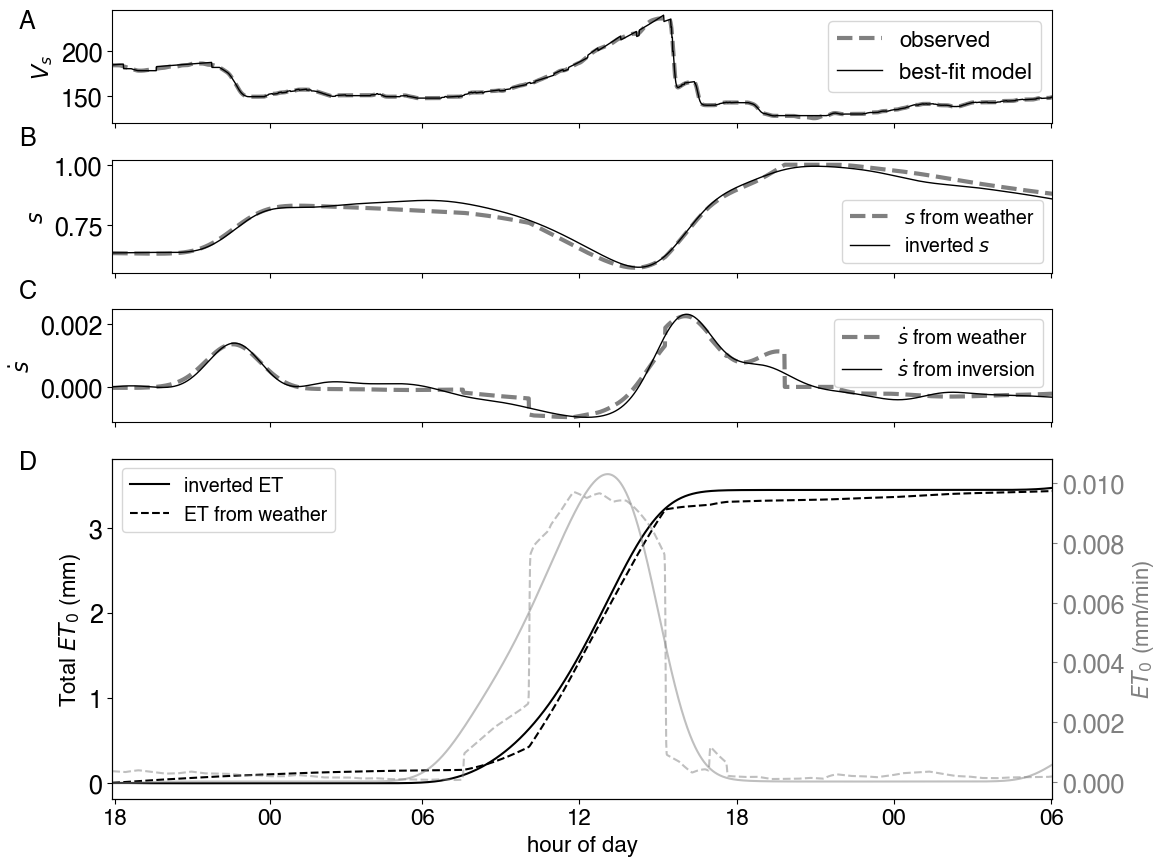

In [91]:
smooth_len = 60  ## smoothing length in minutes

for iloc in [18]:
    ### Lithology parameters
    bulk_density, porosity = interp_bulk_density_10cm[iloc]*1000, interp_porosity_10cm[iloc]/100
    dyn_type = 0
    vs0 = 128

    ### Hydrology parameters
    A_e, A_d, A_p = 1, 0, 1
    drain_dura = 3200
    ini_sw_cor = 0.19
    soil_dep = 12.5

    s0 = interp_humidity[0]/100-0.19
    v_obs = gaussian_filter1d((dvv_all[iloc]+1) * vs0, 0.5)

    ### observed s
    decay = np.exp(-np.arange(8000)/drain_dura)
    res_psd = np.gradient(np.convolve(ave_psd, decay, mode='full')[:2408])
    res_psd[res_psd > 0.24] = 0.24
    psd_smooth = gaussian_filter1d(res_psd, sigma=smooth_len, mode='reflect')
    s_history_smooth = hydro0(psd_smooth, porosity, interp_humidity[0]/100-ini_sw_cor, interp_temp10, 9, eto_every_minute, disturbance_index[iloc-6], A_p,A_e,A_d, length=2408, depth=soil_dep).get_s_history()
    s_rate = np.diff(s_history_smooth, append=s_history_smooth[-1]) / 60 ## Saturation rate, per second


    ### create time series of Vs, s, and s_rate
    v = []
    s_inv = []
    s_rate_inv = []
    err_all = []


    ############################################# Inversion: Lithology
    ### Loop through each time step
    for i in range(2408):

        ### grid search ds/dt
        ds_space = np.arange(-0.01, 0.05, 0.0002)
        obj_func = np.zeros_like(ds_space)
        vs_clay = np.zeros_like(ds_space)
        s_rates = np.zeros_like(ds_space)

        for ii, ds in enumerate(ds_space):
        
            s = min(max(ds+s0, 0), 1)
            s_rates[ii] = (s - s0) / 60
            
            ### Capillary pressure (Sakaki et al. 2010)
            new_f = np.minimum((1 - s), 0.5)
            tau = tau_func(s, s_rates[ii])

            ### Model Vs
            _, vs_clay[ii],   _, _, _, _ = litho1(bulk_density, porosity, 8, new_f, s, s_rates[ii], s_wr, tau, igore_capillary=False).get_vp_vs()
            
            ### MSE error with observed Vs
            obj_func[ii] = (v_obs[i] - vs_clay[ii]) ** 2

        ### Find the best fit at this time step
        best_idx = np.nanargmin(obj_func)
        err_all.append(np.sqrt(obj_func[best_idx]))
        v.append(vs_clay[best_idx])

        s0 = s0 + s_rates[best_idx] * 60
        s_inv.append(s0)


    ### Process the inverted s and s_rate
    v = np.array(v)
    s_inv = gaussian_filter1d(np.array(s_inv), smooth_len)
    s_rate_inv = np.diff(s_inv, append=s_inv[-1]) / 60


    ############################################# Inversion: Hydrology
    ### Inversion using water balance
    etc_rate = hydro1(psd_smooth, porosity, np.array(s_inv), np.array(s_rate_inv) * 60, disturbance_index[iloc-6], A_p,A_e,A_d, length=2408, depth=soil_dep).get_evap()
    etc_rate[1443:2158] = 0
    etc_rate[27:726] = 0
    etc_smooth = gaussian_filter1d(etc_rate, sigma=smooth_len, mode='reflect')
    ### observed ET
    eto_every_minute_smooth = gaussian_filter1d(eto_every_minute, sigma=1, mode='reflect')
    # eto_every_minute_smooth = eto_every_minute_smooth * s_history_smooth * disturbance_index[iloc-6]


    ############################################# FIGURE
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 9), tight_layout=True, gridspec_kw={'height_ratios': [1, 1, 1, 3]}, sharex=True)

    # Plot v_fit
    ax1.plot(np.arange(2408), v_obs, label='observed', color='gray', lw=3, linestyle='--')
    ax1.plot(np.arange(2408), v, label='best-fit model', color='k', lw=1)
    ax1.set_ylabel("$V_s$", fontsize=16)
    ax1.set_xticks(xax)
    ax1.set_xticklabels(hrax, fontsize=16)
    ax1.legend(loc='upper right', fontsize=16)

    # Plot s_rate_fit
    ax2.plot(np.arange(2408), s_history_smooth, label='$s$ from weather', color='gray', lw=3, linestyle='--')
    ax2.plot(np.arange(2408), s_inv, label='inverted $s$', color='k', lw=1)
    ax2.set_ylabel("$s$", fontsize=16)
    ax2.set_xticks(xax)
    ax2.set_xticklabels(hrax, fontsize=16)
    ax2.legend(loc='lower right', fontsize=14)

    # Plot s_fit
    ax3.plot(np.arange(2408), s_rate*60, label='$\dot{s}$ from weather', color='gray', lw=3, linestyle='--')
    ax3.plot(np.arange(2408), np.array(s_rate_inv) * 60, label='$\dot{s}$ from inversion', color='k', lw=1)
    ax3.set_ylabel("$\dot{s}$", fontsize=16)
    ax3.set_xticks(xax)
    ax3.set_xticklabels(hrax, fontsize=16)
    ax3.legend(loc='upper right', fontsize=14)

    # Plot ET 
    ax4.plot(np.arange(acqu_time.shape[0]), np.cumsum(etc_smooth), label='inverted ET', color='k', linestyle='-')
    ax4.plot(np.arange(acqu_time.shape[0]), np.cumsum(eto_every_minute_smooth), label='ET from weather', color='k', linestyle='--')
    ax4.set_ylabel("Total$~ET_0~$(mm)", fontsize=16)
    ax4.set_xlabel("hour of day", fontsize=16)
    ax4.set_xticks(xax)
    ax4.set_xticklabels(hrax, fontsize=16)
    ax4.legend(loc='upper left', fontsize=14)

    ax5 = ax4.twinx()
    ax5.plot(np.arange(acqu_time.shape[0]), etc_smooth, label='inverted $ET_0$', color='gray', linestyle='-', alpha=0.5)
    ax5.plot(np.arange(acqu_time.shape[0]), eto_every_minute_smooth, label='$ET_0$ from weather', color='gray', linestyle='--', alpha=0.5)
    ax5.set_ylabel("$ET_0~$(mm/min)", fontsize=16, color='gray')
    ax5.tick_params(axis='y', colors='gray')
    ax5.set_xticks(xax)
    ax5.set_xticklabels(hrax, fontsize=16)
    ax5.set_xlim(0, 2140)

    fig.text(0.03, 0.95, 'A', fontsize=18)
    fig.text(0.03, 0.82, 'B', fontsize=18)
    fig.text(0.03, 0.65, 'C', fontsize=18)
    fig.text(0.03, 0.46, 'D', fontsize=18)

    plt.savefig(os.path.join(fig_dir, f'ET_inversion_{iloc}.pdf'), dpi=300)